<div style="text-align:center"> 
    <p style="font-size: 50px; margin-bottom: 0">Chemical Cartography</p>
    <p style="font-size: 20px; font-style: italic">ASTR 511 HW3 - Tom Wagg</p>
    <p>(glad we're continuing the theme of c alliteration in these titles haha)</p>
</div>

Author: Tom Wagg

Collaborators: Once again I am failing to collaborate ¯\\\_(ツ)_/¯

In [2]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
quantity_support()

import numpy as np

import pandas as pd
pd.options.display.max_columns = None

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("dark_background")

from gala.dynamics import PhaseSpacePosition
from gala.potential.potential import MilkyWayPotential

from scipy.stats import norm
from scipy.optimize import curve_fit

%config InlineBackend.figure_format = "retina"

# Part 1

## 1.1: The Data

In [3]:
dat = Table.read('allStarLite-dr17-synspec_rev1.fits', format='fits', hdu=1)

In [4]:
f'In this dataset there {len(dat)} stars each with {len(dat.columns)} columns - some of which are themselves multidimensional!!'

'In this dataset there 733901 stars each with 191 columns - some of which are themselves multidimensional!!'

My approximate reaction to this:
![](danger.gif) (plus marvelling too of course, just fearful marvelling)

In [5]:
# drop the multidimensional columns, switch to Pandas because why not and drop the NaNs/flagged stars
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df = df.dropna(subset=["ALPHA_M", "FE_H", "AL_FE", "MG_FE", "MN_FE", "RA", "DEC", "GAIAEDR3_R_MED_GEO",
                       "GAIAEDR3_PMRA", "GAIAEDR3_PMDEC", "GAIAEDR3_DR2_RADIAL_VELOCITY"])
df = df[df["STARFLAG"] == 0]

In [6]:
f'That still leaves us with {len(df)} stars!'

'That still leaves us with 179352 stars!'

## 1.2: Wallerstein-Tinsley Diagram

Now let's plot our favourite new diagram. But first, here are some simple polygons that cover the two discs, I just did these roughly by eye when looking at the plots.

In [7]:
low_alpha_path = mpl.path.Path(
    np.array([
        [-0.5, 0.15],
        [-0.6, 0.15],
        [-0.8, 0.1],
        [-0.7, 0.05],
        [-0.6, 0.03],
        [0, -0.07],
        [0.55, -0.07],
        [0.58, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15]
    ])
)
high_alpha_path = mpl.path.Path(
    np.array([
        [0.4, 0.05],
        [0.2, 0.05],
        [-0.5, 0.15],
        [-1, 0.23],
        [-1.3, 0.28],
        [-1.3, 0.35],
        [-0.25, 0.36],
        [0.4, 0.05]
    ])
)

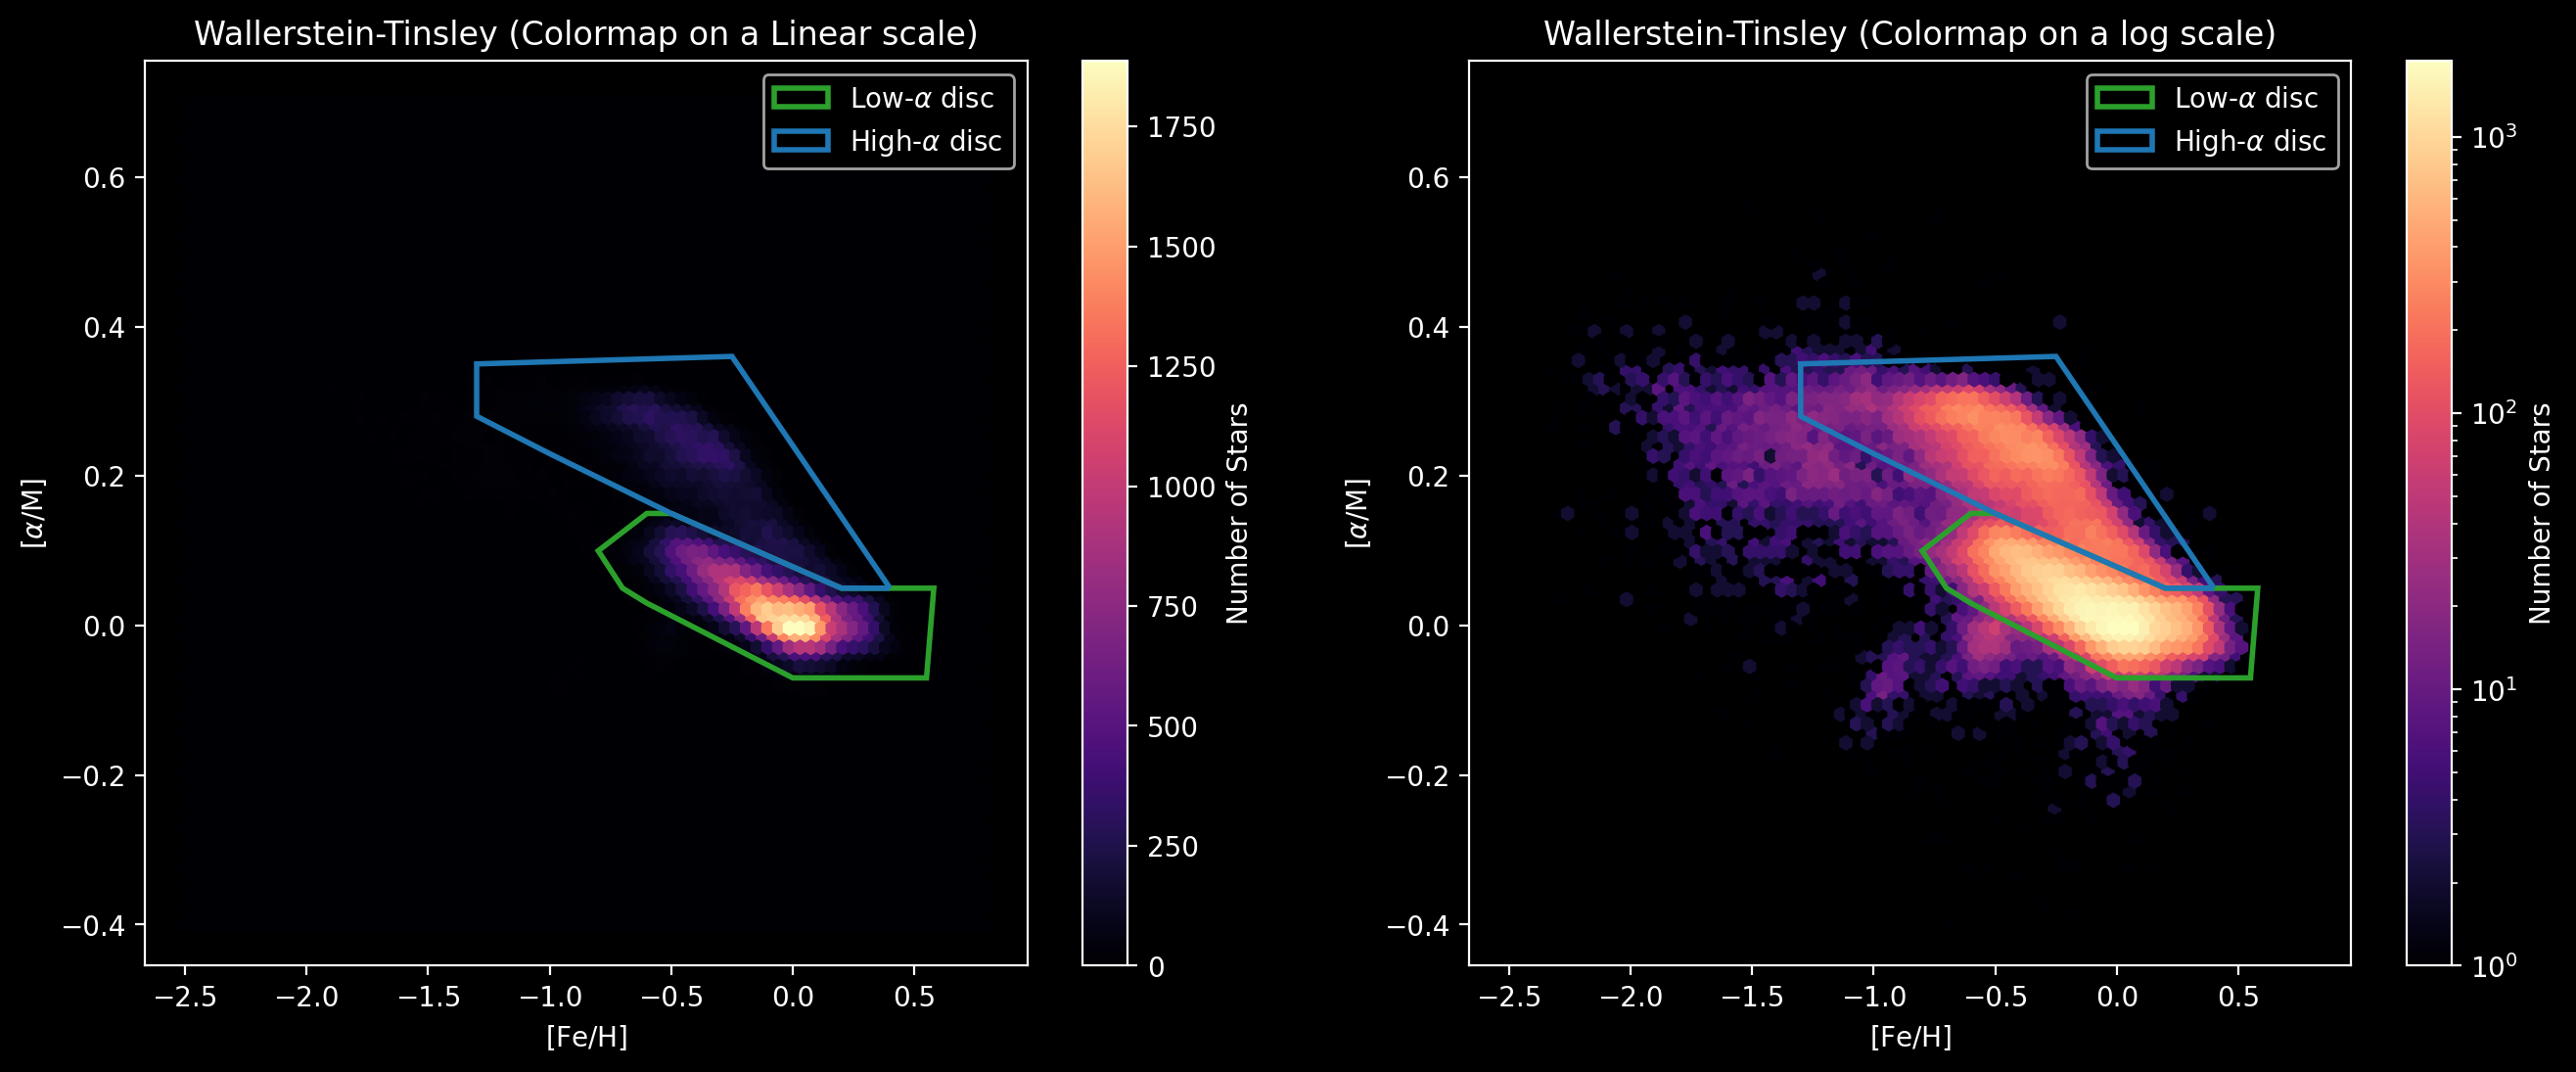

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, scale in zip(axes, [None, "log"]):
    hexbin = ax.hexbin(df["FE_H"], df["ALPHA_M"], cmap="magma", bins=scale, gridsize=75,
                       extent=(-2.5, 0.8, -0.4, 0.7))

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f"Wallerstein-Tinsley (Colormap on a {scale} scale)")

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


We can see the two disc populations emerge very clearly (my cuts getting rid of things without proper motion seem to reduce the high-alpha disc a little unfortunately). In the log-scaled version we can see some other stuff going on at lower $\alpha$ values than the thin disc (no idea what these spikes and clusters of stars are!) and also some extension to lower metallicity in general that probably includes some halo stars.

## 1.3: Dwarfs vs. Giants (Davids  vs. Goliaths??)

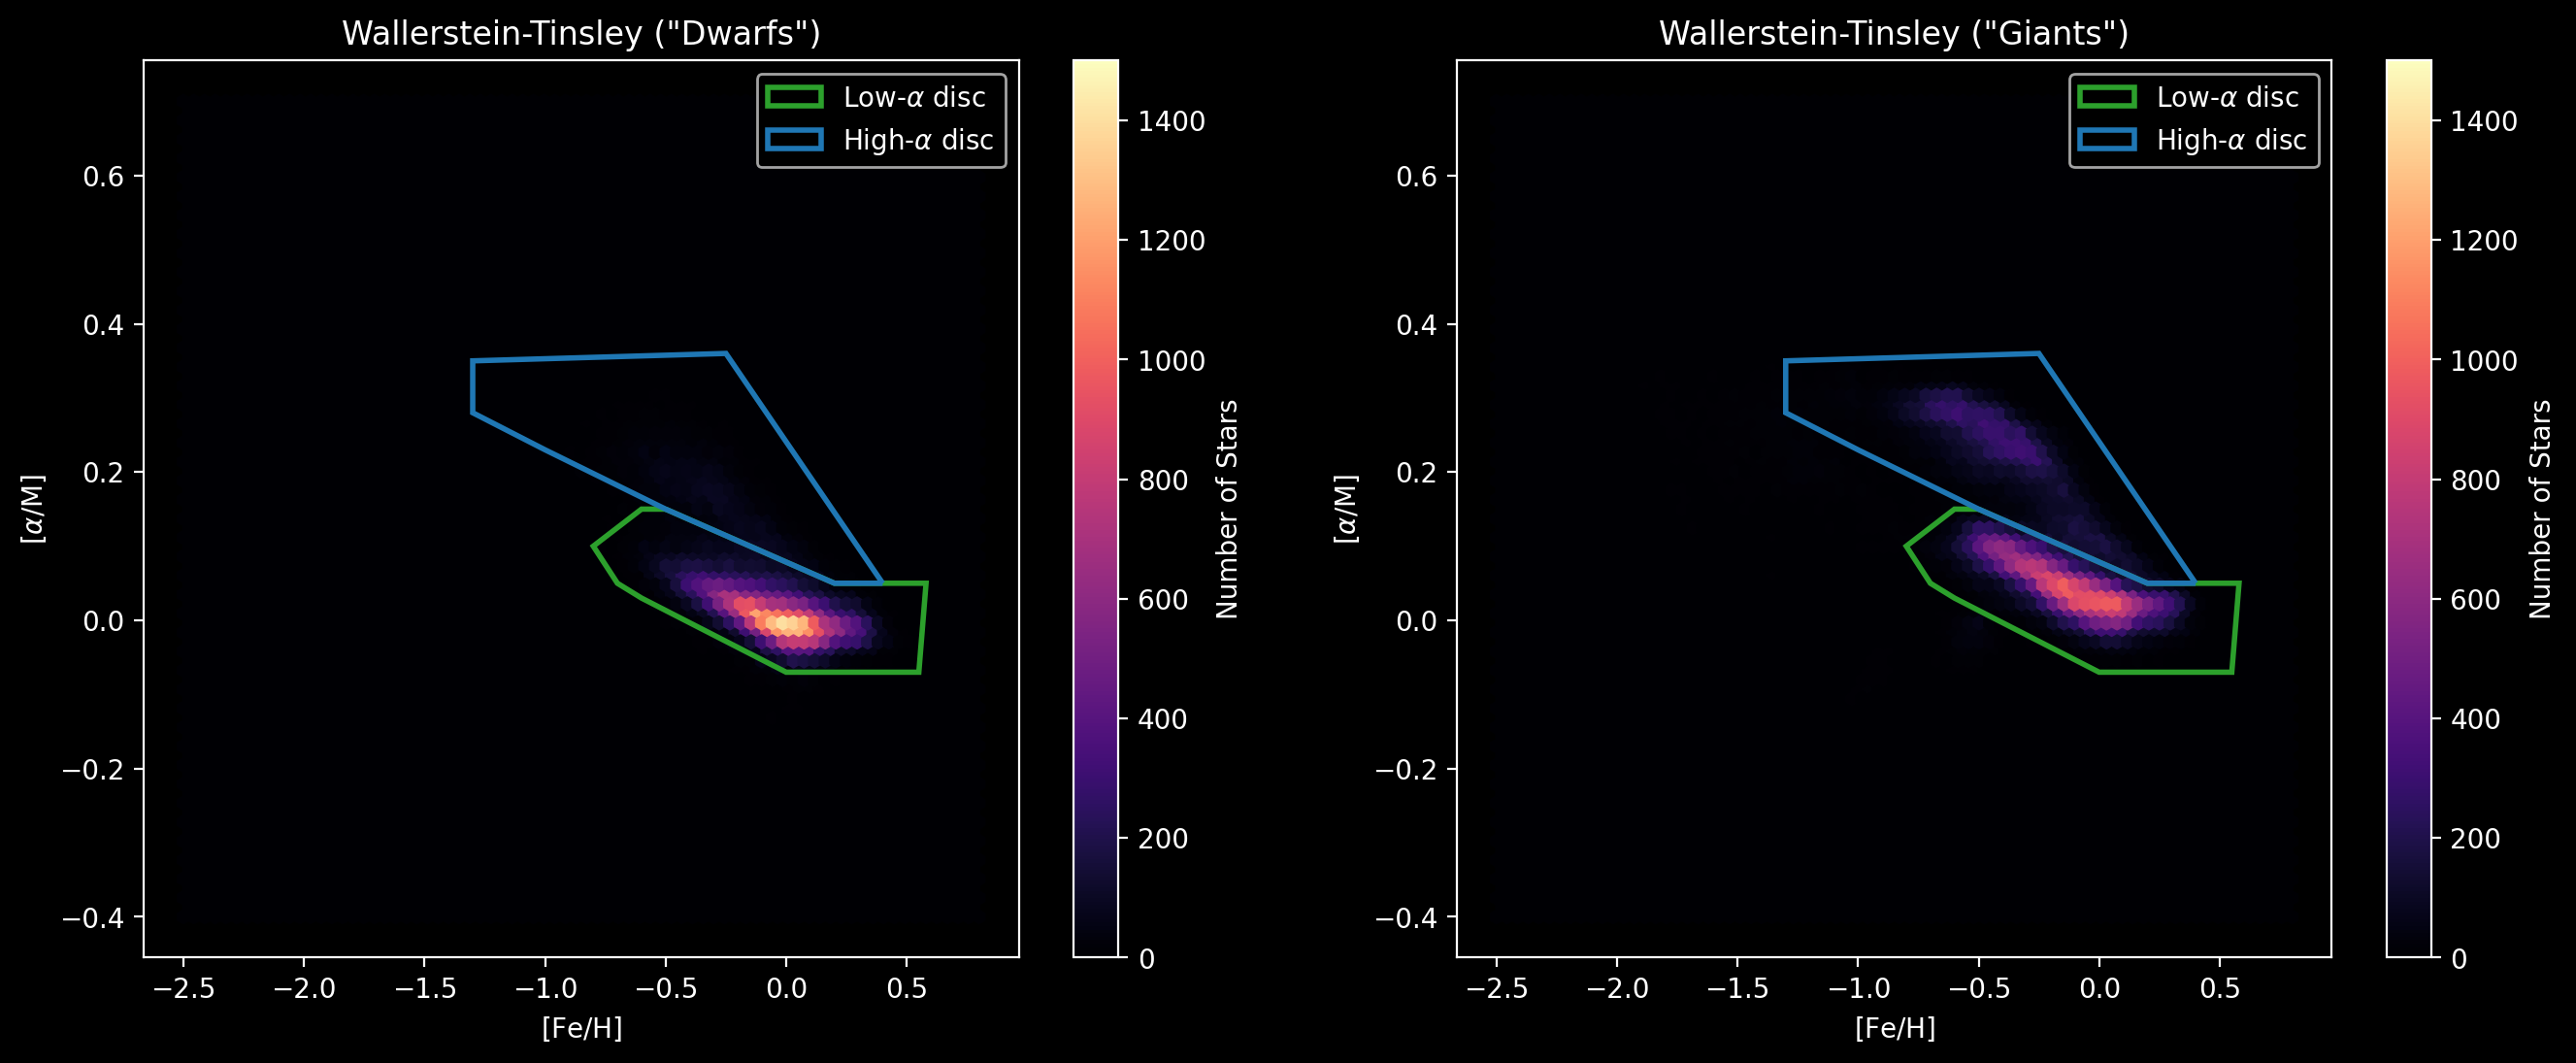

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

dwarfs, giants = (df["LOGG"] >= 3.5), (df["LOGG"] < 3.5)

for ax, mask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    hexbin = ax.hexbin(df["FE_H"][mask], df["ALPHA_M"][mask], cmap="magma", bins=None, gridsize=75,
                       extent=(-2.5, 0.8, -0.4, 0.7), vmax=1500)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                   ["tab:green", "tab:blue"],
                                   [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    fig.colorbar(hexbin, label="Number of Stars", ax=ax)

    if scale is None:
        scale = "Linear"
    ax.set_title(f'Wallerstein-Tinsley (\"{title}\")')

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.legend()

plt.show()


So it looks to me like both discs are present for the Giants, but we can only see thin disc for the Dwarfs! However the thin-disc is more prominent for the dwarfs. So it seems that doing this split can help us track each of the discs with each population!

# Part Two

Now let's look at how thing are distributed _physically_!

## 2.1: Scale heights

### Go galactocentric and mask masks

First we can create a SkyCoord from the positions and transform to Galactocentric. I also trimmed this to focus on close to the midplane.

In [10]:
coords = SkyCoord(ra=df["RA"].values * u.deg,
                  dec=df["DEC"].values * u.deg,
                  distance=df["GAIAEDR3_R_MED_GEO"].values * u.pc,
                  frame="icrs").transform_to("galactocentric")
close_z = np.abs(coords.z.to(u.kpc).value) < 5

In [11]:
low_alpha_mask = low_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)
high_alpha_mask = high_alpha_path.contains_points(np.stack((df['FE_H'], df['ALPHA_M'])).T)

### Dwarfs vs. Giants: The Rematch

I find 69016 Dwarfs in the Low-$\alpha$ disc
I find 7371 Dwarfs in the High-$\alpha$ disc
I find 67096 Giants in the Low-$\alpha$ disc
I find 29970 Giants in the High-$\alpha$ disc


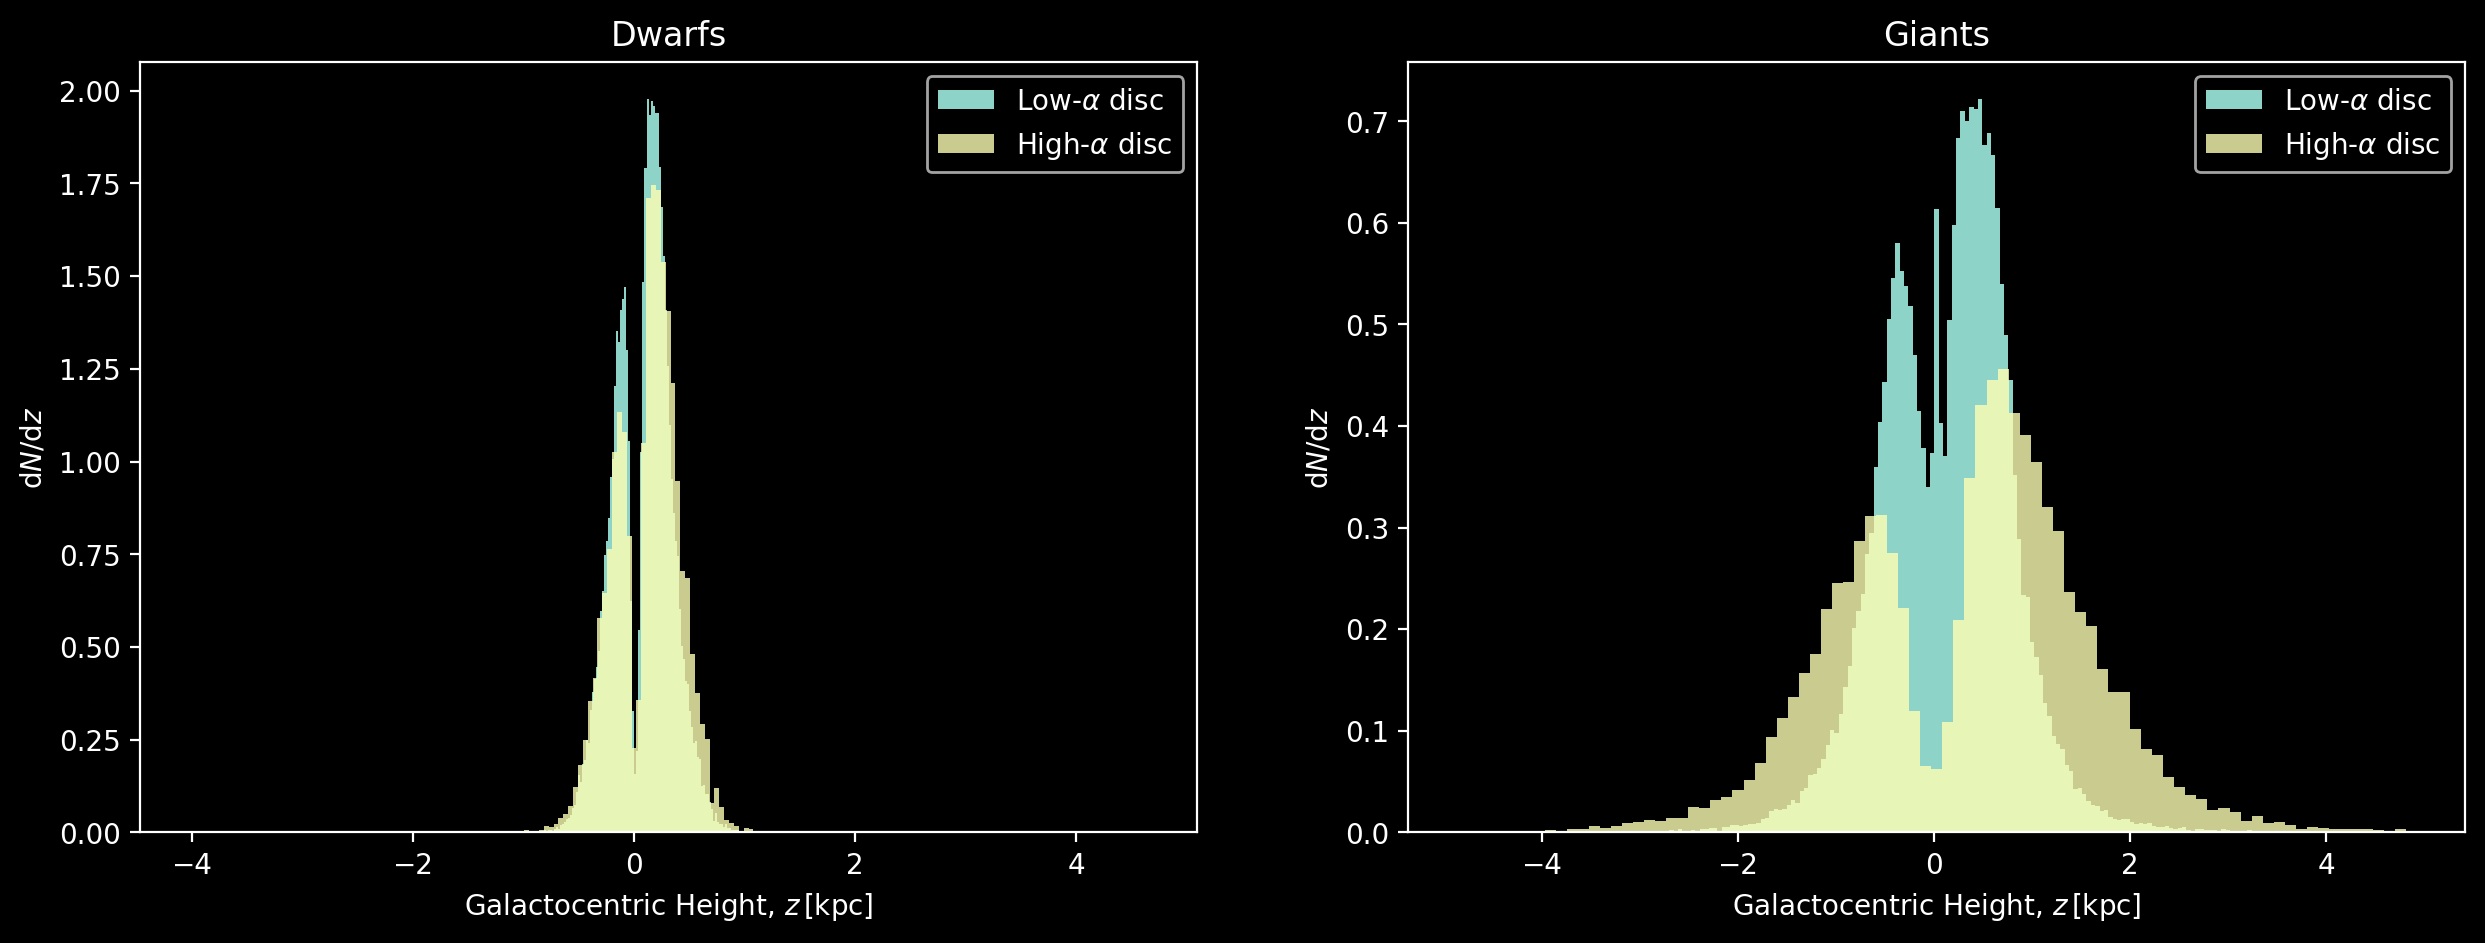

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, dgmask, title in zip(axes, [dwarfs, giants], ["Dwarfs", "Giants"]):
    for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        print(f'I find {(close_z & mask & dgmask).sum()} {title} in the {label}')
        ax.hist(coords.z.to(u.kpc).value[close_z & mask & dgmask], bins="fd", density=True, color=colour,
                alpha=0.8 if colour == "C1" else 1, zorder=-1, label=label);
    ax.set_title(title)

for ax in axes:
    ax.legend()
    ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
    ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

As we expected from above, it seems like the dwarfs trace the thin disc well whilst the giants trace the thick disc better.

It is also important to note that extinction is at work here! Things near the midplane are going to have a lot more extinction and so we get dips near $z = 0$ in all of these plots.

### Fit scale heights

Now we can use `scipy` to fit Gaussians to each of the discs in order to estimate the scale heights.

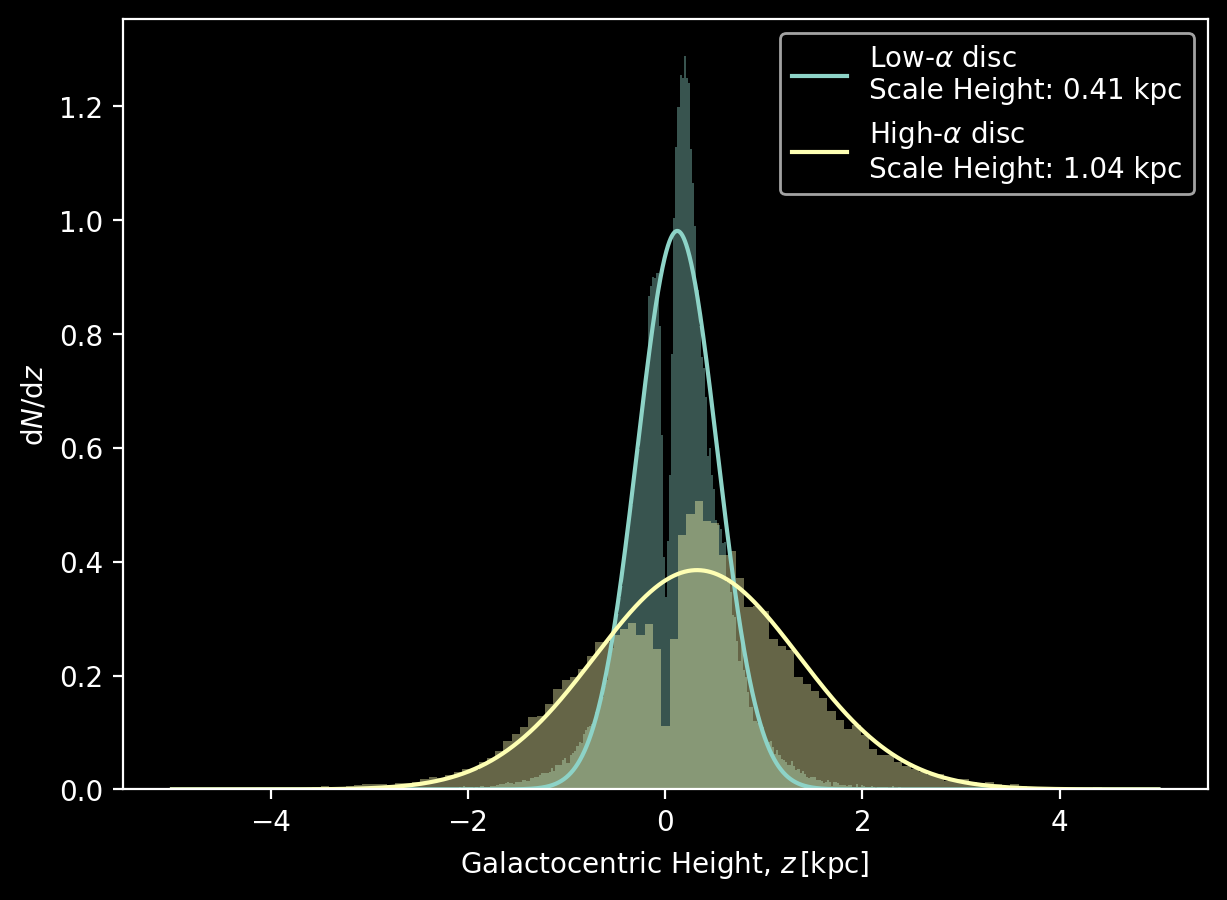

In [13]:
def gaussian(x, mu, sigma):
    return norm.pdf(x, loc=mu, scale=sigma)

fig, ax = plt.subplots(figsize=(7, 5))

for mask, colour, label in zip([low_alpha_mask, high_alpha_mask], ["C0", "C1"], [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
    h, bins = np.histogram(coords.z.to(u.kpc).value[close_z & mask], bins="fd", density=True)
    bin_centres = (bins[1:] + bins[:-1]) / 2
    popt, pcov = curve_fit(gaussian, xdata=bin_centres, ydata=h)

    ax.hist(coords.z.to(u.kpc).value[close_z & mask], bins="fd", density=True, color=colour, alpha=0.4, zorder=-1);

    mu, sigma = popt
    z_range = np.linspace(-5, 5, 10000)
    ax.plot(z_range, gaussian(z_range, mu, sigma), color=colour, label=label + f"\nScale Height: {sigma:1.2f} kpc")

ax.legend()
ax.set_xlabel(r"Galactocentric Height, $z \, [\rm kpc]$")
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}z$")

plt.show()

And given that we made many assumptions and didn't account for any selection effects we did a pretty reasonable job! Certainly the relative scale heights are about right and the absolute values are not far off :D

## 2.2: Mean metallicity in plane

How does metallicity vary as we meander our way across the galaxy? What about $[\alpha, {\rm M}]$? Let's find out!

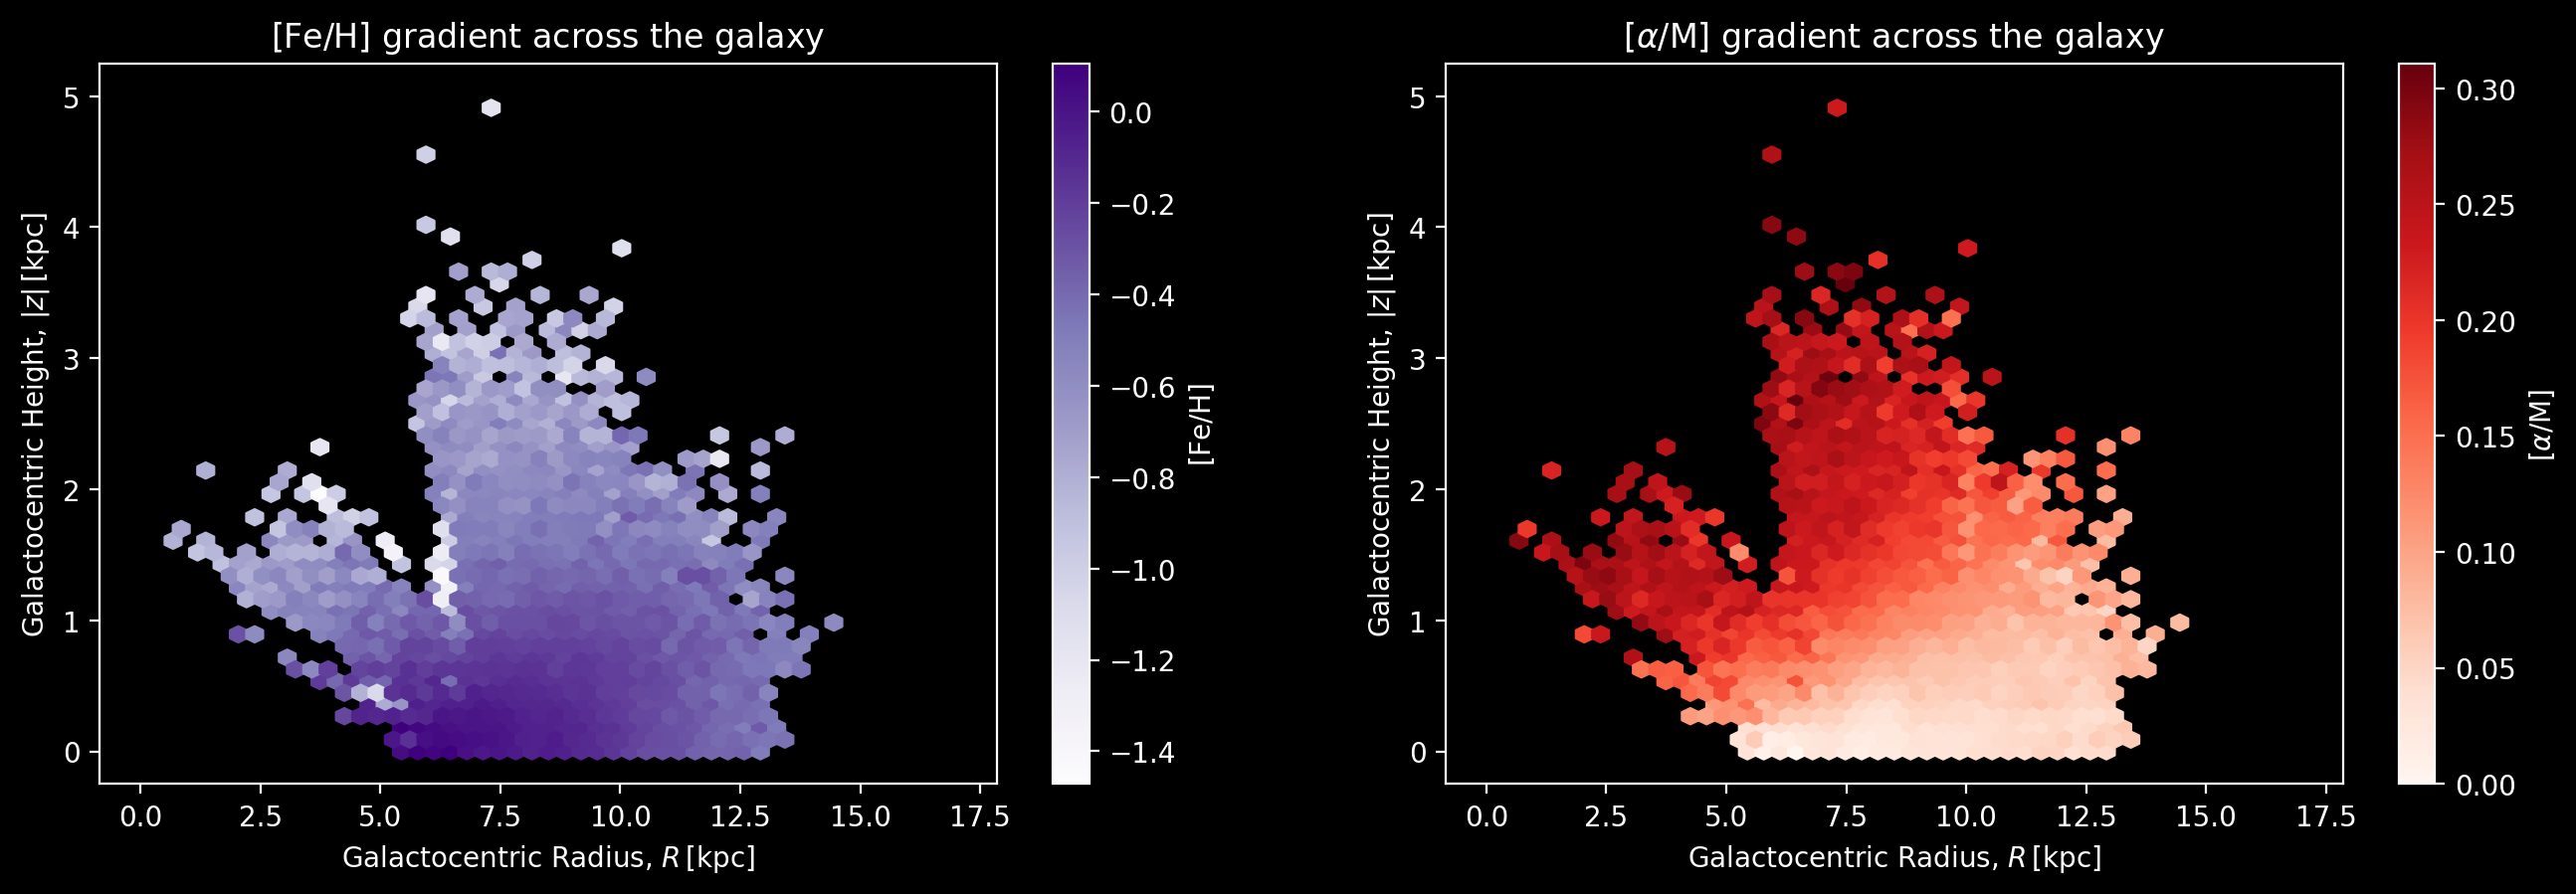

In [14]:
R = ((coords.x**2 + coords.y**2)**(0.5)).to(u.kpc).value

# get the mean as long as you've got some minimum number of stars
def reduce_func(x):
    if len(x) > 5:
        return np.mean(x)
    else:
        return np.nan

fig, axes = plt.subplots(1, 2, figsize=(16, 10 / 17 * 8))

for ax, cmap, C, label in zip(axes, ["Purples", "Reds"],
                              [df["FE_H"].values, df["ALPHA_M"].values],
                              [r"$\rm [Fe / H]$", r"$[\alpha / {\rm M}]$"]):
    hexbin = ax.hexbin(R, np.abs(coords.z.to(u.kpc).value),
                    C=C, reduce_C_function=reduce_func,
                    extent=(0, 17, 0, 5), cmap=cmap, gridsize=50)

    fig.colorbar(hexbin, label=label, ax=ax)

    ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric Height, $|z| \, [\rm kpc]$")

    ax.set_title(f"{label} gradient across the galaxy")

plt.show()

Here I'm plotting 2D histograms of Galactocentric radius against absolute height above the midplane and showing the mean $\rm [Fe / H]$ and $[\alpha / {\rm M}]$ for each bin that hast least 5 stars.

We can see that as you increase in radius and/or height $\rm [Fe / H]$ decreases, where the trend is more abrupt in $z$ than in $R$. For $[\alpha / {\rm M}]$ there isn't much as much of a gradient across radius but there is a strong increase in $[\alpha / {\rm M}]$ as you move away from the midplane.

# Part 3: How the Sausage Gets Made
(An overambitious section title but someone needed to use it)

## 3.1: Grab the accreted stars
Jim said we can either do this using relative abundances or by kinematics. I figure that there's only one sensible response to this:

![](both.gif) onwards!

### The abundance way
For this we are going to copy our friends [Carrillo et al. 2022](https://arxiv.org/abs/2202.10416) and explore the $\rm ([Al/Fe], [Mg/Mn])$ plane. 

p.s. It took me an embarrassingly long time to work out why my plot looked dodgy until I realise I needed to subtract and not divide the Mg and Mn because they are in log space oops haha.

In [15]:
# get the values and work out the area containing the vast majority of stars
mg_mn = (df["MG_FE"] - df["MN_FE"]).values
al_fe = df["AL_FE"].values
lims = [0.2, 99.7]
extent = tuple(np.concatenate((np.percentile(df["AL_FE"], lims), np.percentile(mg_mn, lims))))

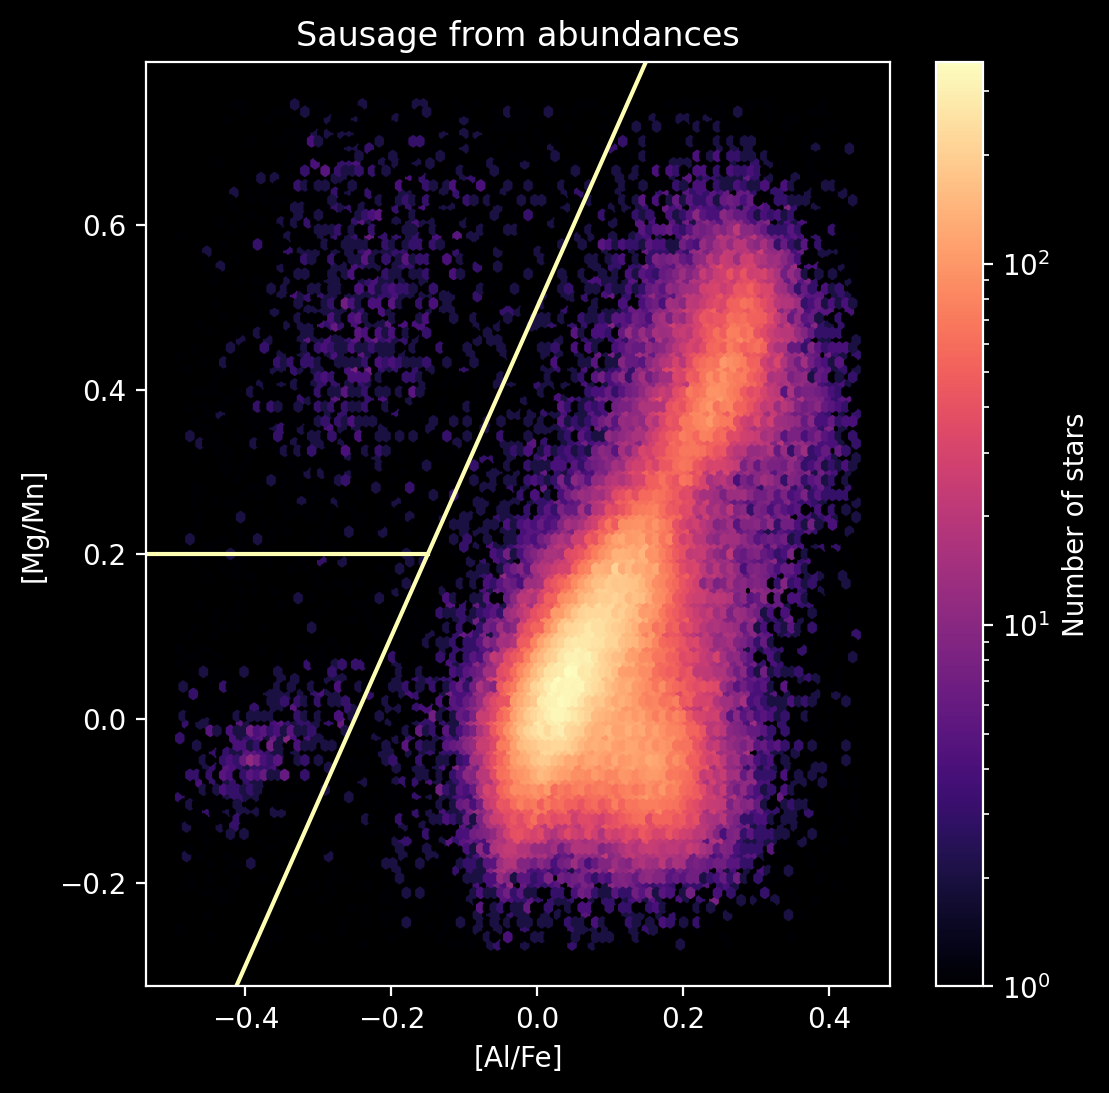

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

hexbin = ax.hexbin(al_fe, mg_mn, extent=extent, bins="log", cmap="magma")
fig.colorbar(hexbin, label="Number of stars")

xlims = ax.set_xlim()
ylims = ax.set_ylim()

al_fe_range = np.array([extent[0], extent[1]])
ax.plot(al_fe_range, al_fe_range * 2 + 0.5, color="C1")
ax.plot([xlims[0], (0.2 - 0.5) / 2], [0.2, 0.2], color="C1")

ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_xlabel("[Al/Fe]")
ax.set_ylabel("[Mg/Mn]")

ax.set_title("Sausage from abundances")

plt.show()

We can see a clear population separated to the left of the main galactic population and we can isolate this with some simple cuts indicated by the lines above. Note I'm coming back to the thing in the bottom left in a bit - see section 3.

In [17]:
sausage_chemical = (al_fe * 2 + 0.5 < mg_mn) & (mg_mn > 0.2)
f'This gives us {sausage_chemical.sum()} stars in the sausage'

'This gives us 2760 stars in the sausage'

### The kinematic way

And now switching gears, let's try it from another angle and imitate these smart folks: [Fernandes et al. 2023](https://arxiv.org/abs/2301.01302). For this we're going to need to add the velocities in addition to the positions to the SkyCoord.

In [18]:
# expand the coords from before to include velocities as well as positions
coords = SkyCoord(ra=df["RA"].values * u.deg,
                  dec=df["DEC"].values * u.deg,
                  distance=df["GAIAEDR3_R_MED_GEO"].values * u.pc,
                  pm_ra_cosdec=df["GAIAEDR3_PMRA"].values * np.cos(df["DEC"].values * u.deg) * u.mas / u.yr,
                  pm_dec=df["GAIAEDR3_PMDEC"].values * u.mas / u.yr,
                  radial_velocity=df["GAIAEDR3_DR2_RADIAL_VELOCITY"].values * u.km / u.s,
                  frame="icrs").transform_to("galactocentric")

Now we can take these Galactocentric coordinates and load them into `Gala` as a `PhaseSpacePosition`.

In [19]:
w = PhaseSpacePosition(pos=[coords.x.to(u.kpc).value,
                            coords.y.to(u.kpc).value,
                            coords.z.to(u.kpc).value] * u.kpc,
                       vel=[coords.v_x.to(u.km / u.s).value,
                            coords.v_y.to(u.km / u.s).value,
                            coords.v_z.to(u.km / u.s).value] * u.km / u.s)

After this it is pretty simple to use `Gala` to get the energy and momentum (assuming `Gala`'s default `MilkyWayPotential`).

In [20]:
E = w.energy(MilkyWayPotential()).to(u.km**2 / u.s**2)
L_z = w.angular_momentum()[2, :].to(u.km * u.kpc / u.s)

And now we can just plot it up! My version seems to have the momentum sign flipped compared to the paper but I figured I'd leave it as is.

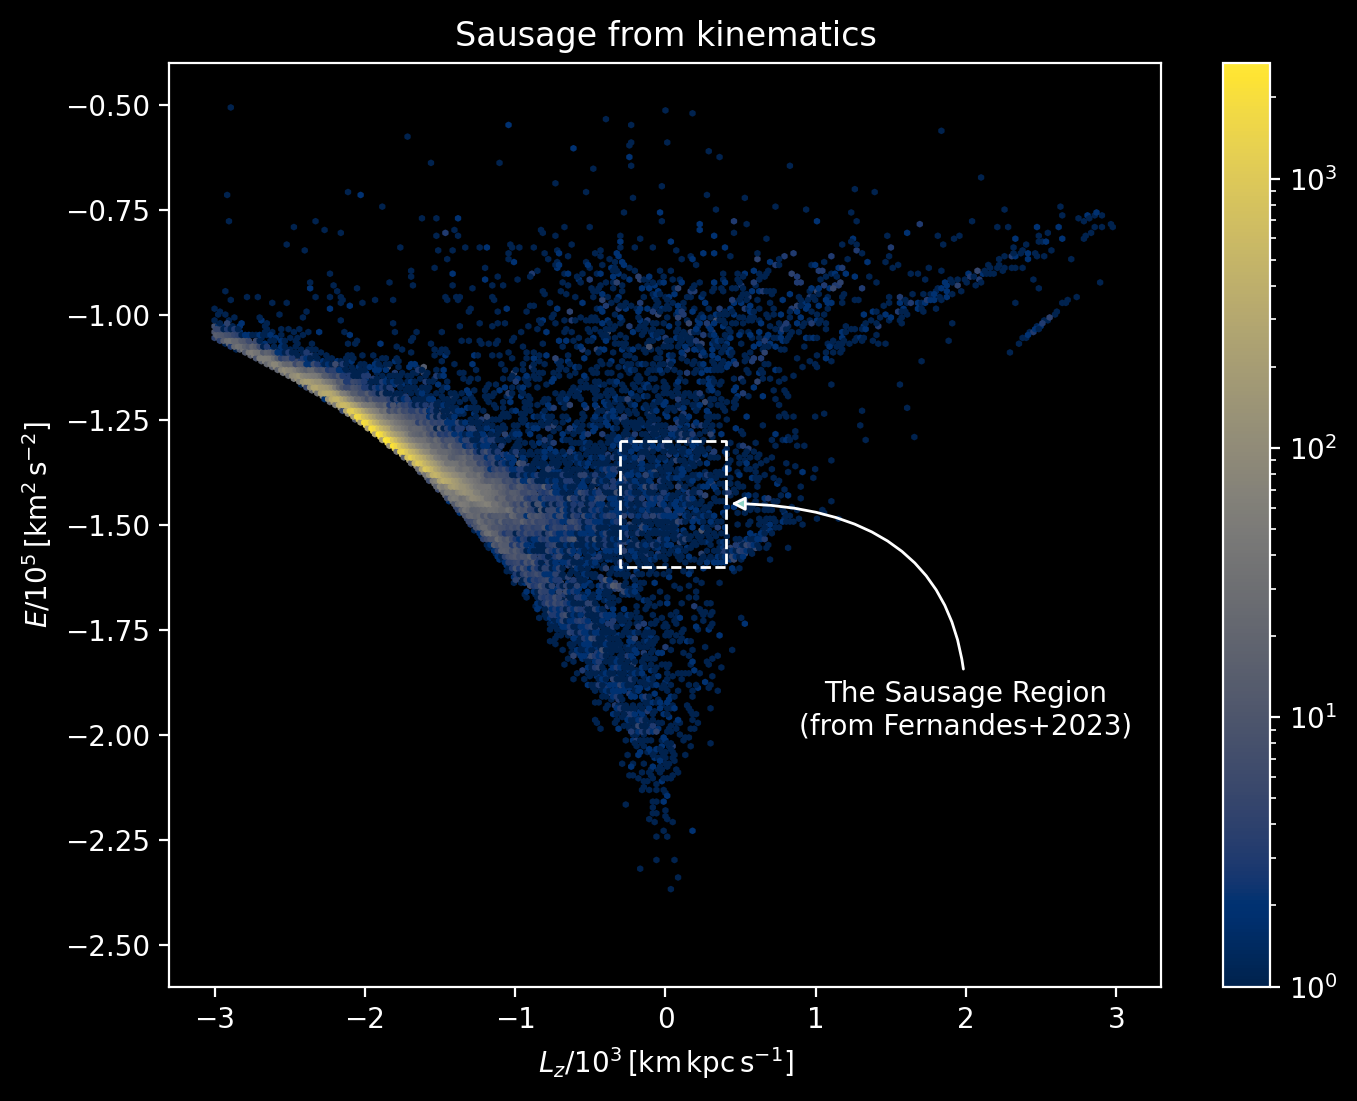

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

hexbin = ax.hexbin(L_z / 1e3, E / 1e5, extent=(-3, 3, -2.5, -0.5), bins="log", gridsize=250, cmap="cividis")
fig.colorbar(hexbin)

ax.fill_between([-0.3, 0.4], -1.6, -1.3, facecolor="none", linestyle="--")
ax.annotate("The Sausage Region\n(from Fernandes+2023)", xy=(0.4, -1.45), xytext=(2, -2), ha="center",
            arrowprops=dict(arrowstyle="-|>", connectionstyle="angle3"))

ax.set_xlabel(r"$L_z / 10^{3} \, [\rm km \, kpc \, s^{-1}]$")
ax.set_ylabel(r"$E / 10^{5} \, [\rm km^2 \, s^{-2}]$")

ax.set_title("Sausage from kinematics")

plt.show()

I've added on the rectangle region that the paper suggests for getting the Sausage out. We can use this as a mask in the same way as the previous subsection.

In [22]:
sausage_kin = ((E / 1e5 < -1.3 * u.km**2 / u.s**2)
               & (E / 1e5 > -1.6 * u.km**2 / u.s**2)
               & (L_z / 1e3 < 0.4 * u.km * u.kpc / u.s)
               & (L_z / 1e3 > -0.3 * u.km * u.kpc / u.s))
f'We find {sausage_kin.sum()} stars matching this mask'

'We find 1025 stars matching this mask'

## 3.2: Where is it?

### Wallerstein-Tinsley

Let's do scatter plots and make a separate panel for the masks separately and then the combination of the two.

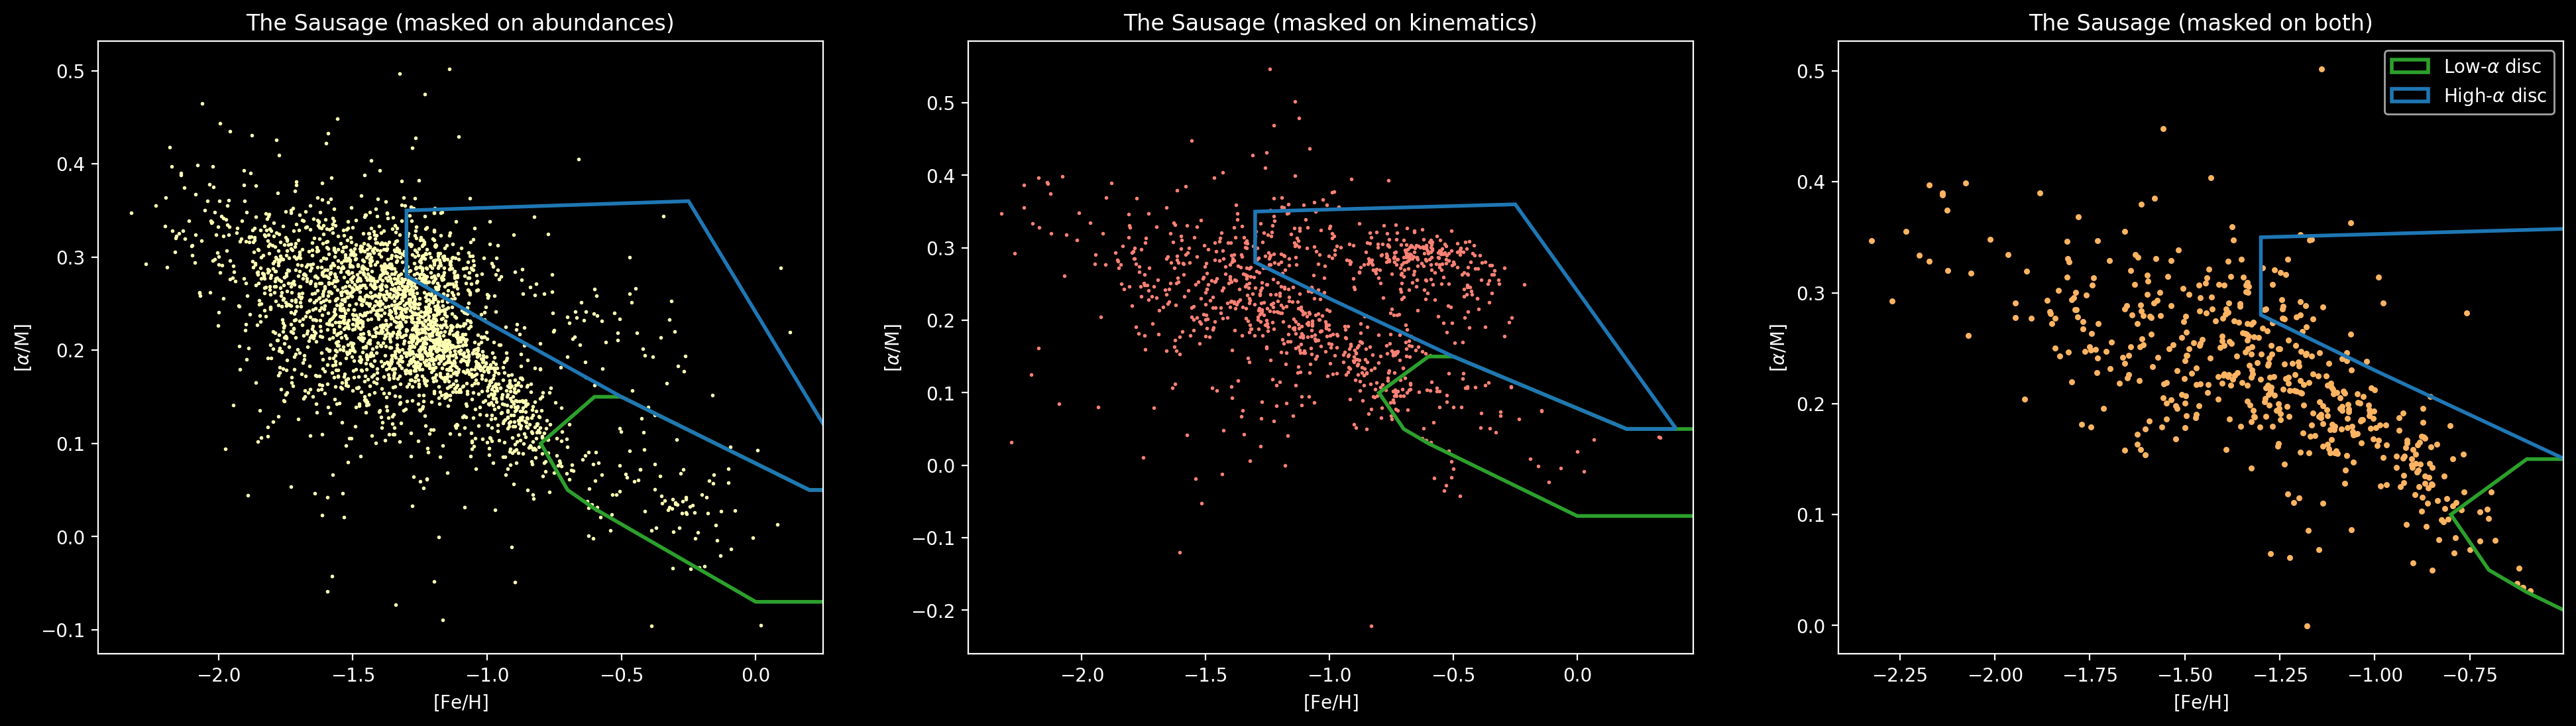

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(df["FE_H"][mask], df["ALPHA_M"][mask], s=5 if what == "both" else 1, color=colour)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                    ["tab:green", "tab:blue"],
                                    [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        ax.add_artist(patch)

    ax.set_xlabel(r"$\rm [Fe / H]$")
    ax.set_ylabel(r"$[\alpha / {\rm M}]$")

    ax.set_title(f"The Sausage (masked on {what})")

ax.legend()

plt.show()

The overall population seems to span many different components and doesn't seem to be constrain to any of them. You can see differences in the methods, using abundances separates it more clearly from the discs whilst kinematics doesn't have the same effect. Taking the overlap of the two puts the population firmly outside of the discs, at lower metallicities.

### (R-Z) plane
Same again but this time we're talking about physical location!

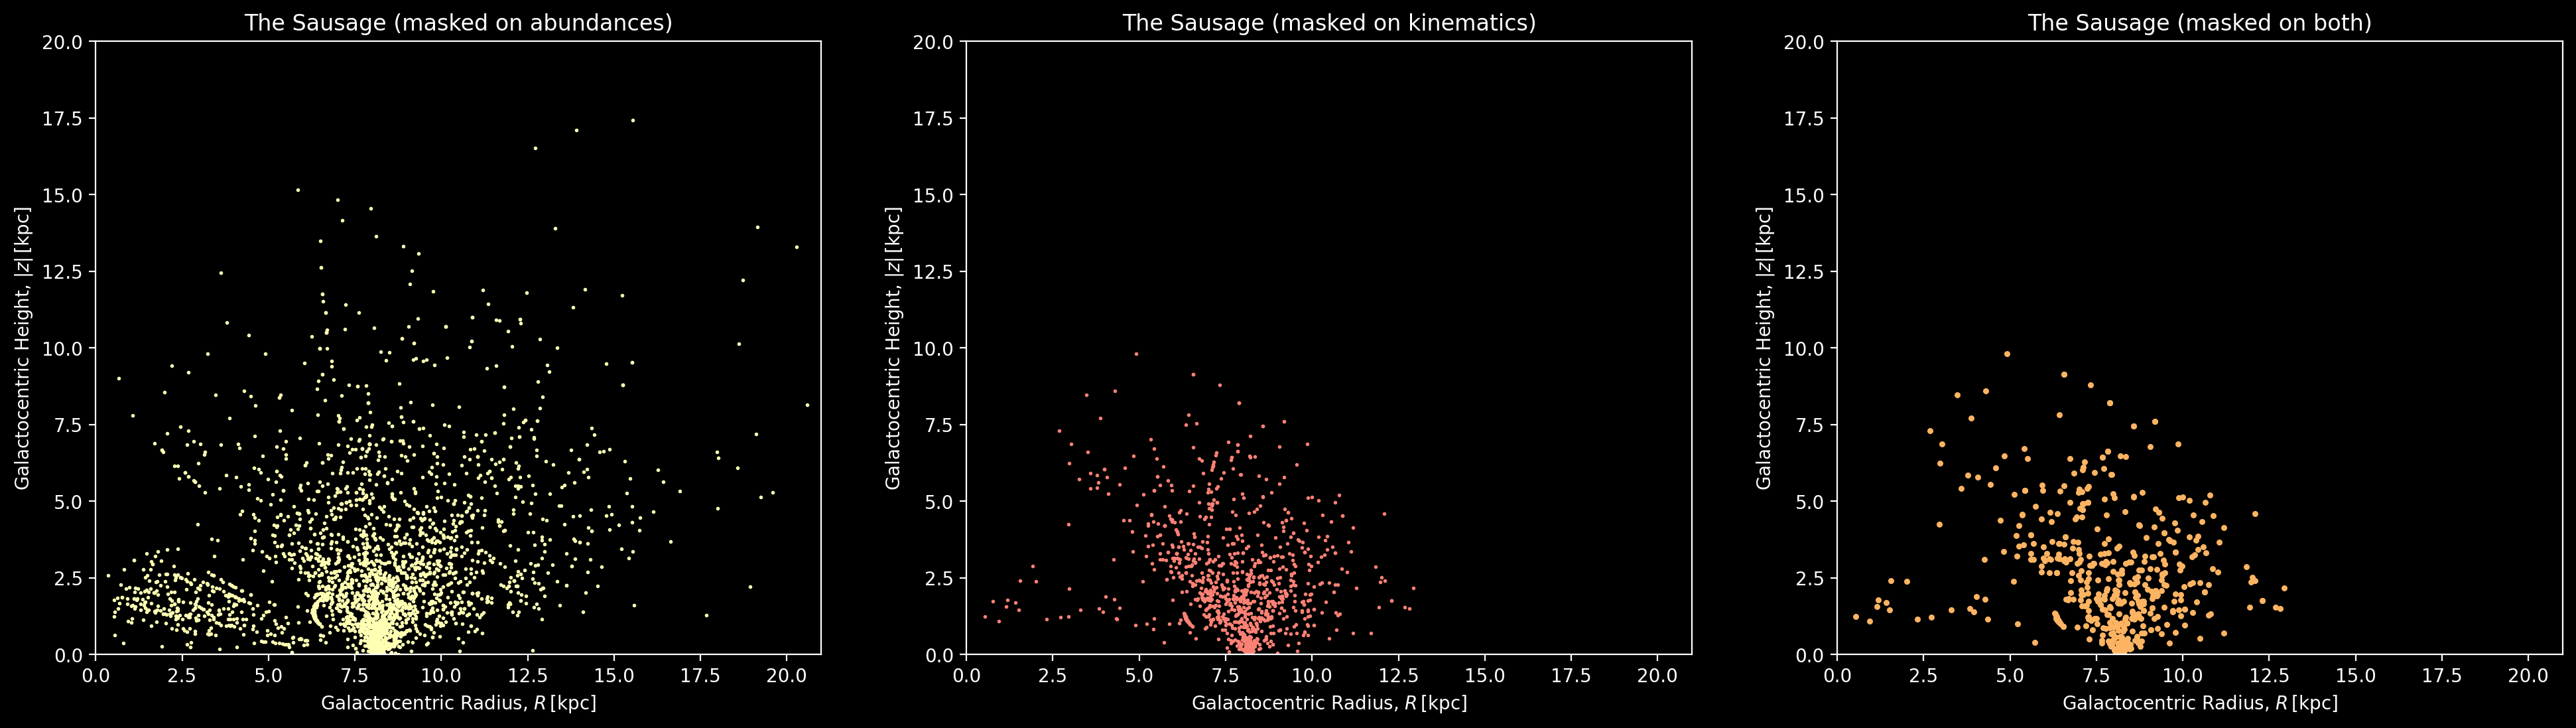

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(R[mask], np.abs(coords.z[mask].to(u.kpc)), s=5 if what == "both" else 1, color=colour)

    ax.set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric Height, $|z| \, [\rm kpc]$")

    ax.set_title(f"The Sausage (masked on {what})")

    ax.set_xlim(0, 21)
    ax.set_ylim(0, 20)

plt.show()

My first thought from this plot is how large the scale height of this population is, when using both masks it seems to span about the same range in height as in radius!! As before you can see differences in the methods, using abundances gives a wide range of locations across the galaxy but kinematics restricts it to be within a more constrained region.

And just because I'm curious, what happens if we look down onto the Galaxy

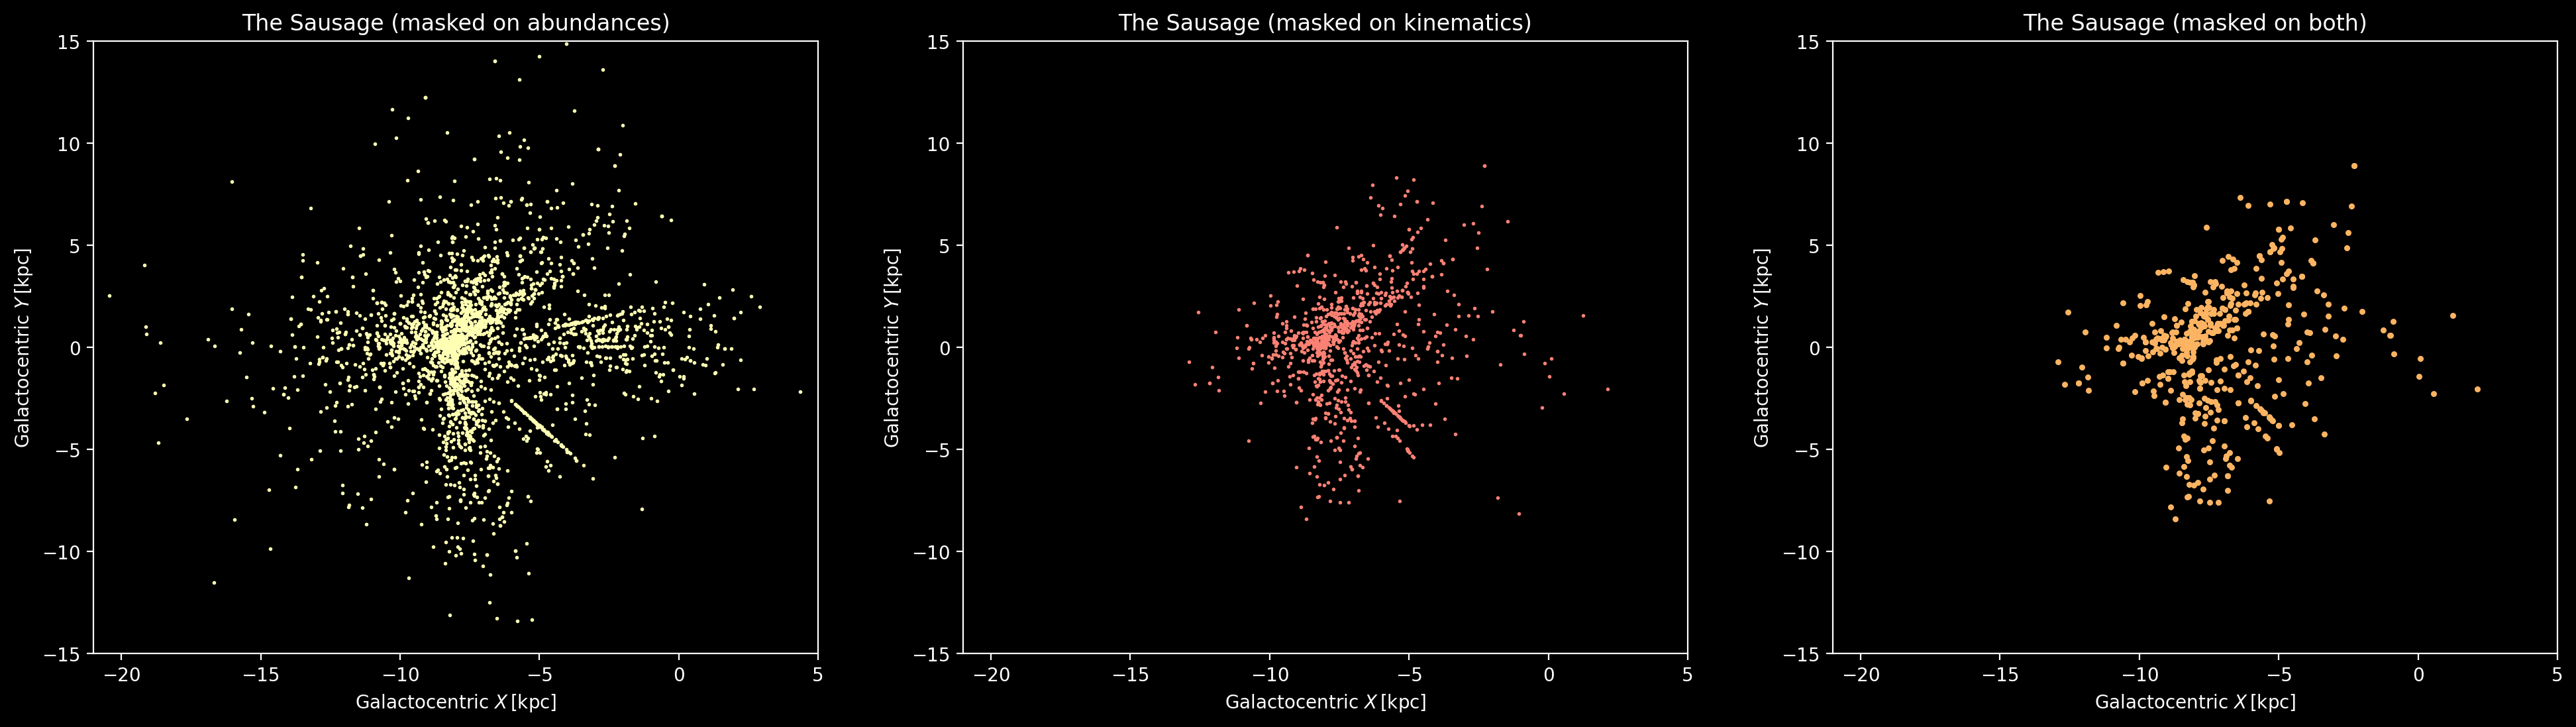

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for ax, mask, colour, what in zip(axes,
                                  [sausage_chemical, sausage_kin, sausage_chemical & sausage_kin],
                                  ["C1", "C3", "C5"],
                                  ["abundances", "kinematics", "both"]):
    ax.scatter(coords.x[mask].to(u.kpc), coords.y[mask].to(u.kpc), s=5 if what == "both" else 1, color=colour)

    ax.set_xlabel(r"Galactocentric $X \, [\rm kpc]$")
    ax.set_ylabel(r"Galactocentric $Y \, [\rm kpc]$")

    ax.set_title(f"The Sausage (masked on {what})")

    ax.set_xlim(-21, 5)
    ax.set_ylim(-15, 15)

plt.show()

Again no real restriction to any specific location (other than being near the Earth because that's easier to see) - this thing is everywhere!

## Part 3.3: Random Investigations

#### The "Not-Sausage" (The Burger!?)

So first of all I was intrigued to see what was going on with the "not-Sausage" clump from the plot in the earlier section. I guess burgers are not sausages so I'm calling it that. Let's take a look at where this thing lies on the usual plots

In [334]:
# this makes my life easier
def investigate_mask(mask, show_background=False):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].scatter(df["FE_H"][mask], df["ALPHA_M"][mask], s=2)
    if show_background:
        axes[0].scatter(df["FE_H"], df["ALPHA_M"], s=0.1, zorder=-1)

    for path, colour, label in zip([low_alpha_path, high_alpha_path],
                                    ["tab:green", "tab:blue"],
                                    [r"Low-$\alpha$ disc", r"High-$\alpha$ disc"]):
        patch = mpl.patches.PathPatch(path, fc='none', edgecolor=colour, lw=2, label=label)
        axes[0].add_artist(patch)

    axes[0].set_xlabel(r"$\rm [Fe / H]$")
    axes[0].set_ylabel(r"$[\alpha / {\rm M}]$")

    axes[1].scatter(R[mask], np.abs(coords.z[mask].to(u.kpc)), s=1)
    if show_background:
        axes[1].scatter(R, np.abs(coords.z.to(u.kpc)), s=0.1, zorder=-1)

    axes[1].set_xlabel(r"Galactocentric Radius, $R \, [\rm kpc]$")
    axes[1].set_ylabel(r"Galactocentric Height, $|z| \, [\rm kpc]$")

    plt.show()

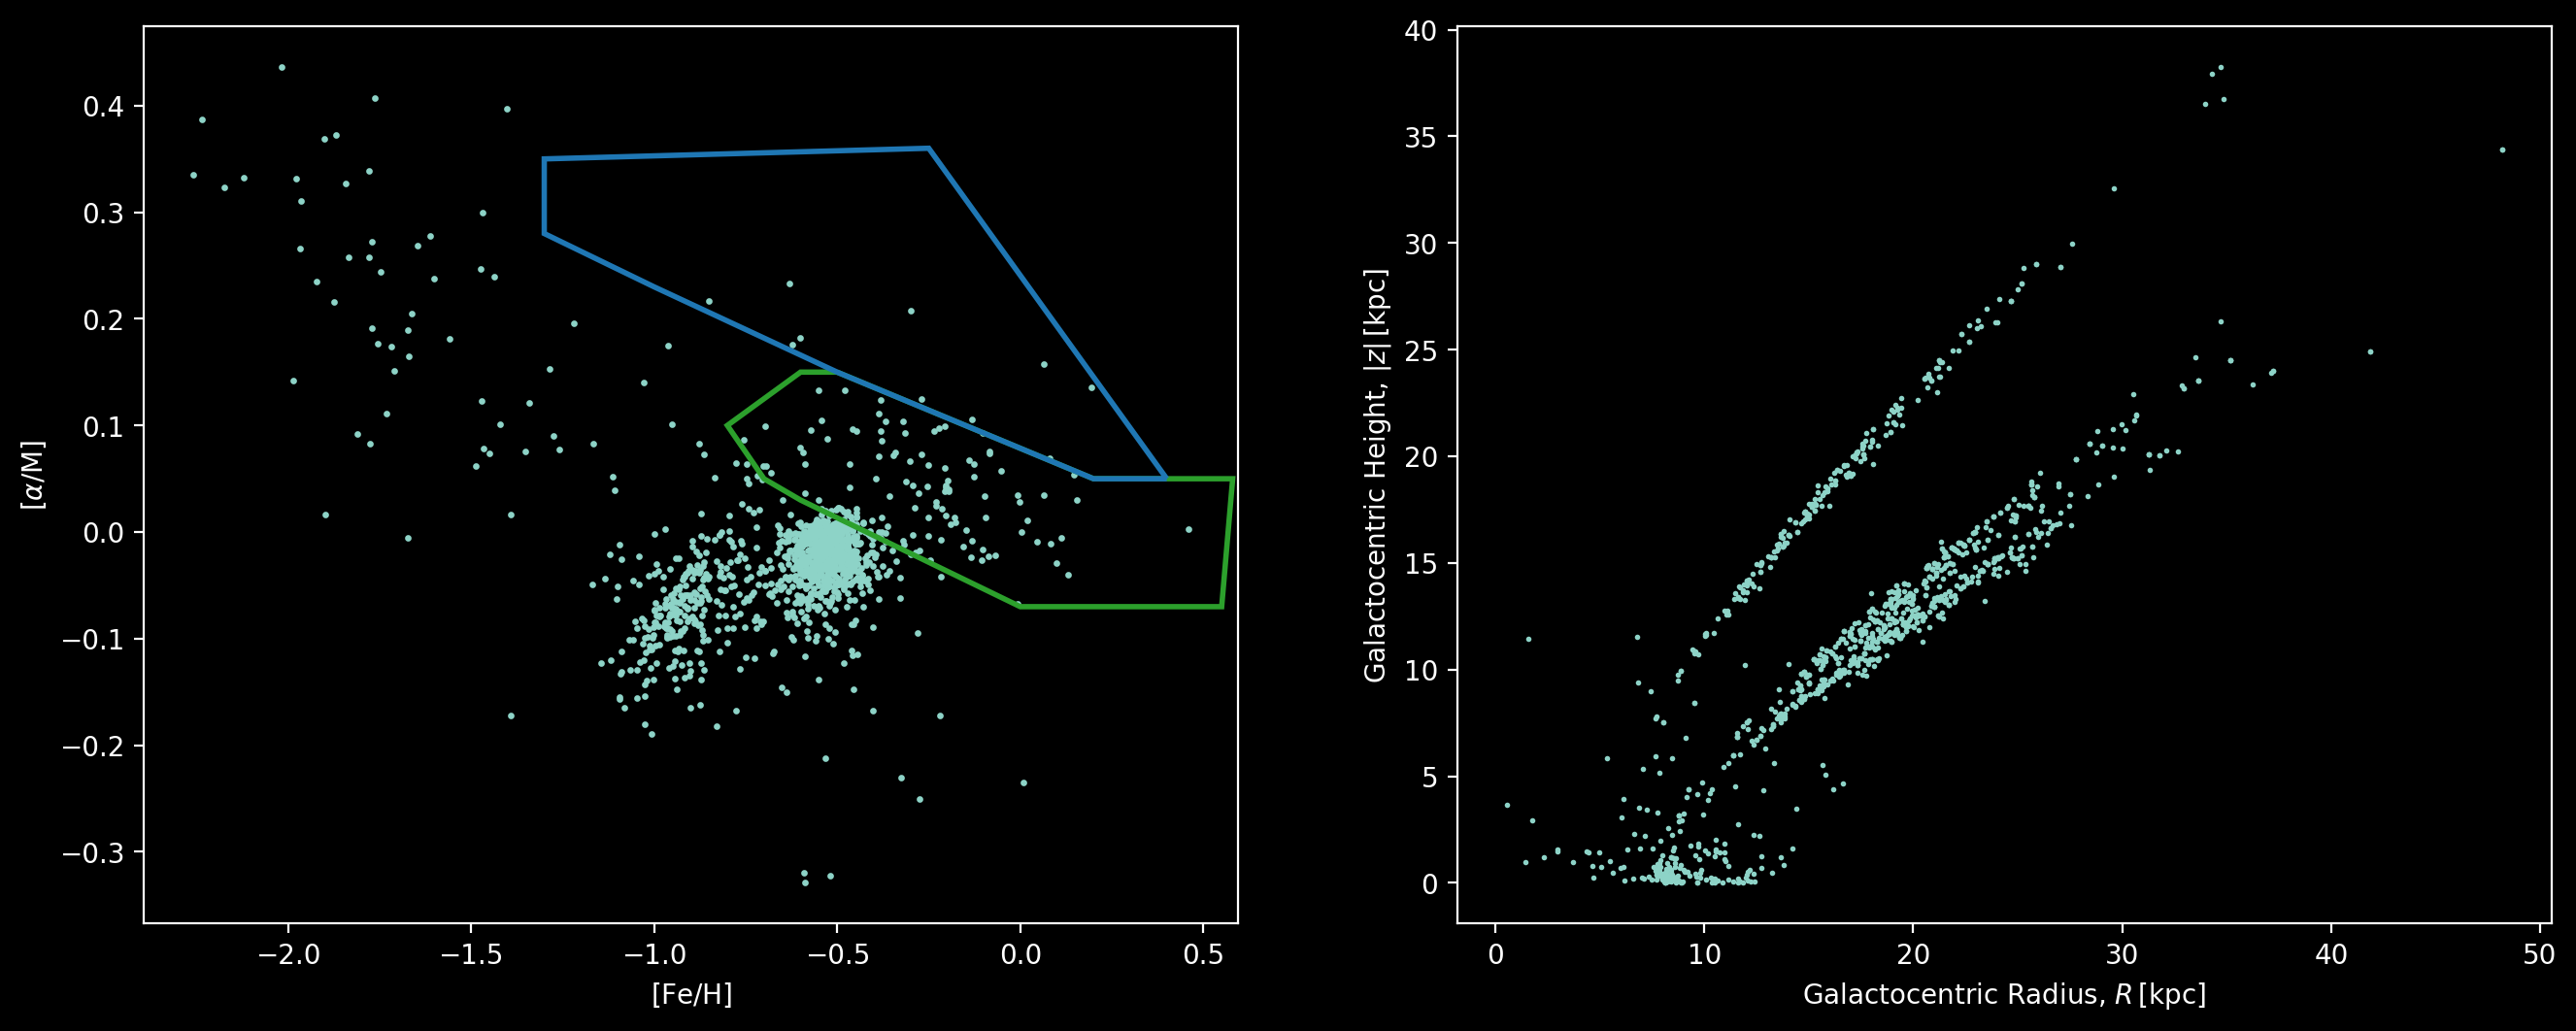

In [336]:
burger = (al_fe * 2 + 0.5 < mg_mn) & (mg_mn < 0.2)
investigate_mask(burger)

Intriguing. So it seems this not-Sausage is definitely something else. We see that the metallicity is lower than the thin disc and the values of $R$ seem to be very large (as usual I'm ignoring uncertainties but I checked and they aren't that different than the general population). There's definitely a very distinct kinematic shape there though! What happens if we look at the distances?

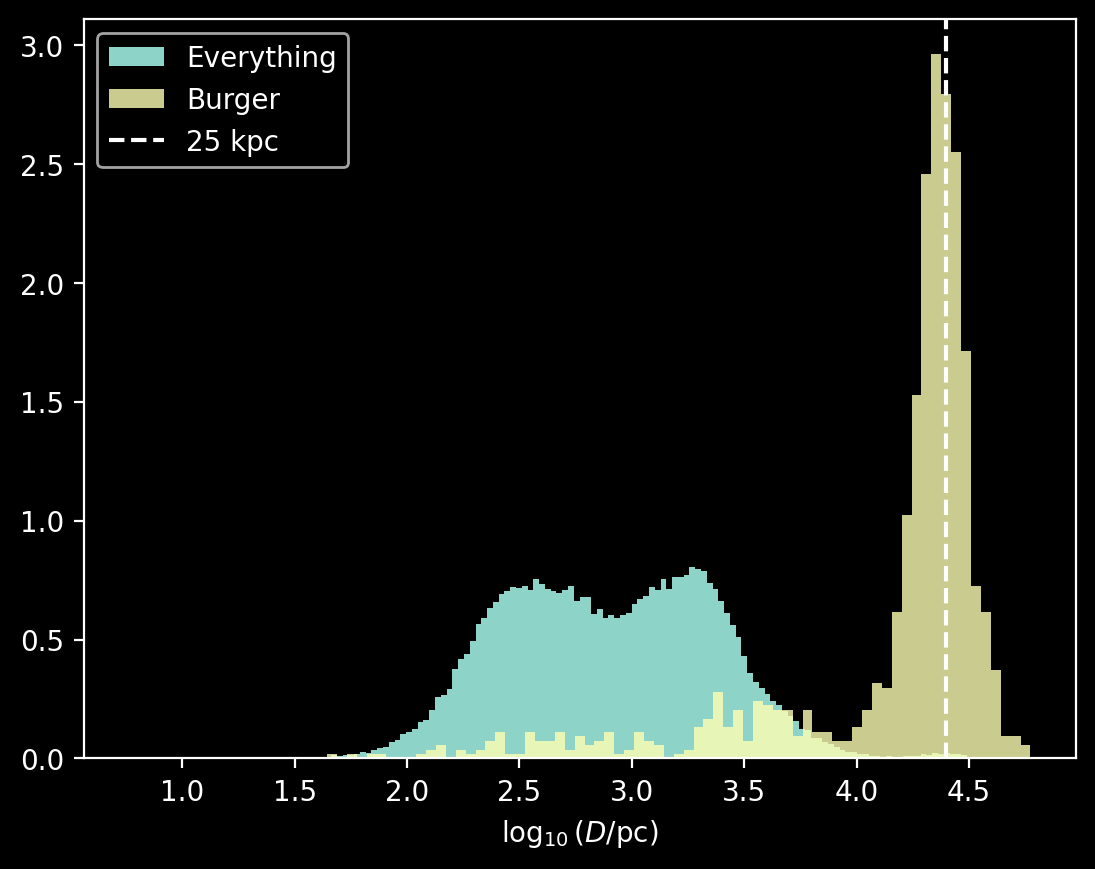

In [337]:
plt.hist(np.log10(df["GAIAEDR3_R_MED_GEO"]), bins="fd", density=True, label="Everything")
plt.hist(np.log10(df["GAIAEDR3_R_MED_GEO"])[burger], bins="fd", density=True, alpha=0.8, label="Burger")
plt.axvline(np.log10(25000), c="white", linestyle="--", label="25 kpc")
plt.legend()
plt.xlabel(r"$\log_{10}(D/{\rm pc})$");

So it's definitely far away!! But only half the distance to the SMC which is what I was expecting...

Is my burger actually a magellanic cloud? Unsure!

#### An exercise in combinatorics I guess

I wasn't entirely sure what to look for here so I made a quick framework for making corner plots of abundances for comparing the many (many) *many* options in the file.

In [280]:
not_disc = ~(low_alpha_mask | high_alpha_mask)

def abundance_from_str(df, a, b):
    if b == "FE":
        return df[f'{a}_{b}'].values
    else:
        return df[f'{a}_FE'].values - df[f'{b}_FE'].values

def label_from_str(a, b):
    return f'[{a[0]}{a[1:].lower()}/{b[0]}{b[1:].lower()}]'

def compare_abundances(abundance_list, fig_scale=4, point_size=0.1, bins="fd", scatter_perc_lims=[0.01, 99.99],
                       highlight_sausage=True, include_discs=False):
    """Compare abundances from an APOGEE in a big ol' corner plot

    Parameters
    ----------
    abundance_list : `list` of `tuples`
        A list of pairs of elements to show the abundances for (e.g. [("AL", "FE"), ("NA", "O"), ...])
    fig_scale : `int`, optional
        How big to make each panel, by default 4
    point_size : `float`, optional
        Scatter point size, by default 0.1
    bins : `str`, optional
        Bins to use for histograms, by default "fd"
    scatter_perc_lims : `list`, optional
        Percentiles at which to limit the axes, by default [0.01, 99.99]
    highlight_sausage : `bool`, optional
        Whether to highlight constituents of the Gaia-Enceladous Sausage, by default True
    include_discs : `bool`, optional
        Whether to include stars identified as being part of the discs, by default False
    """
    not_disc = np.repeat(True, len(df)) if include_discs else ~(low_alpha_mask | high_alpha_mask)

    # work out the abundances and labels
    abundances = [abundance_from_str(df, a, b) for a, b in abundance_list]
    labels = [label_from_str(a, b) for a, b in abundance_list]
    n = len(abundances)

    fig, axes = plt.subplots(n, n, figsize=(fig_scale * n, fig_scale * n))

    # go over every axis
    for i in range(n):
        for j in range(n):
            # blank out the top half of the triangle
            if j > i:
                axes[i, j].axis("off")
                continue

            # draw histograms on the diagonal
            if j == i:
                axes[i, j].hist(abundances[i][not_disc], bins=bins, density=True)

            # draw scatter plots on the others
            else:
                axes[i, j].scatter(abundances[j][not_disc], abundances[i][not_disc], s=point_size, label="Not discs or GE/S")

                if highlight_sausage:
                    axes[i, j].scatter(abundances[j][sausage_chemical], abundances[i][sausage_chemical],
                                       s=point_size, label="GE/S")

        axes[-1, i].set_xlabel(labels[i])
        axes[i, 0].set_ylabel(labels[i])


    # work out the axis limits and set them
    lims = [np.percentile(abund[~np.isnan(abund)], scatter_perc_lims) for abund in abundances]
    for i in range(len(abundances)):
        for ax in axes[:, i]:
            ax.set_xlim(lims[i])

        for j in range(len(abundances)):
            if j != i:
                axes[i, j].set_ylim(lims[i])

    # add a legend if highlighting the sausage
    if highlight_sausage:
        axes[1, 0].legend(markerscale=30, bbox_to_anchor=(2, 2), fontsize="large",
                          handletextpad=0.0, title="Legend for scatter plots")

    # big old title
    axes[0, -1].annotate("Abundance\nComparison", xy=(0.75, 0.75), xycoords="axes fraction", ha="right", va="top", fontsize=75)

    plt.show()

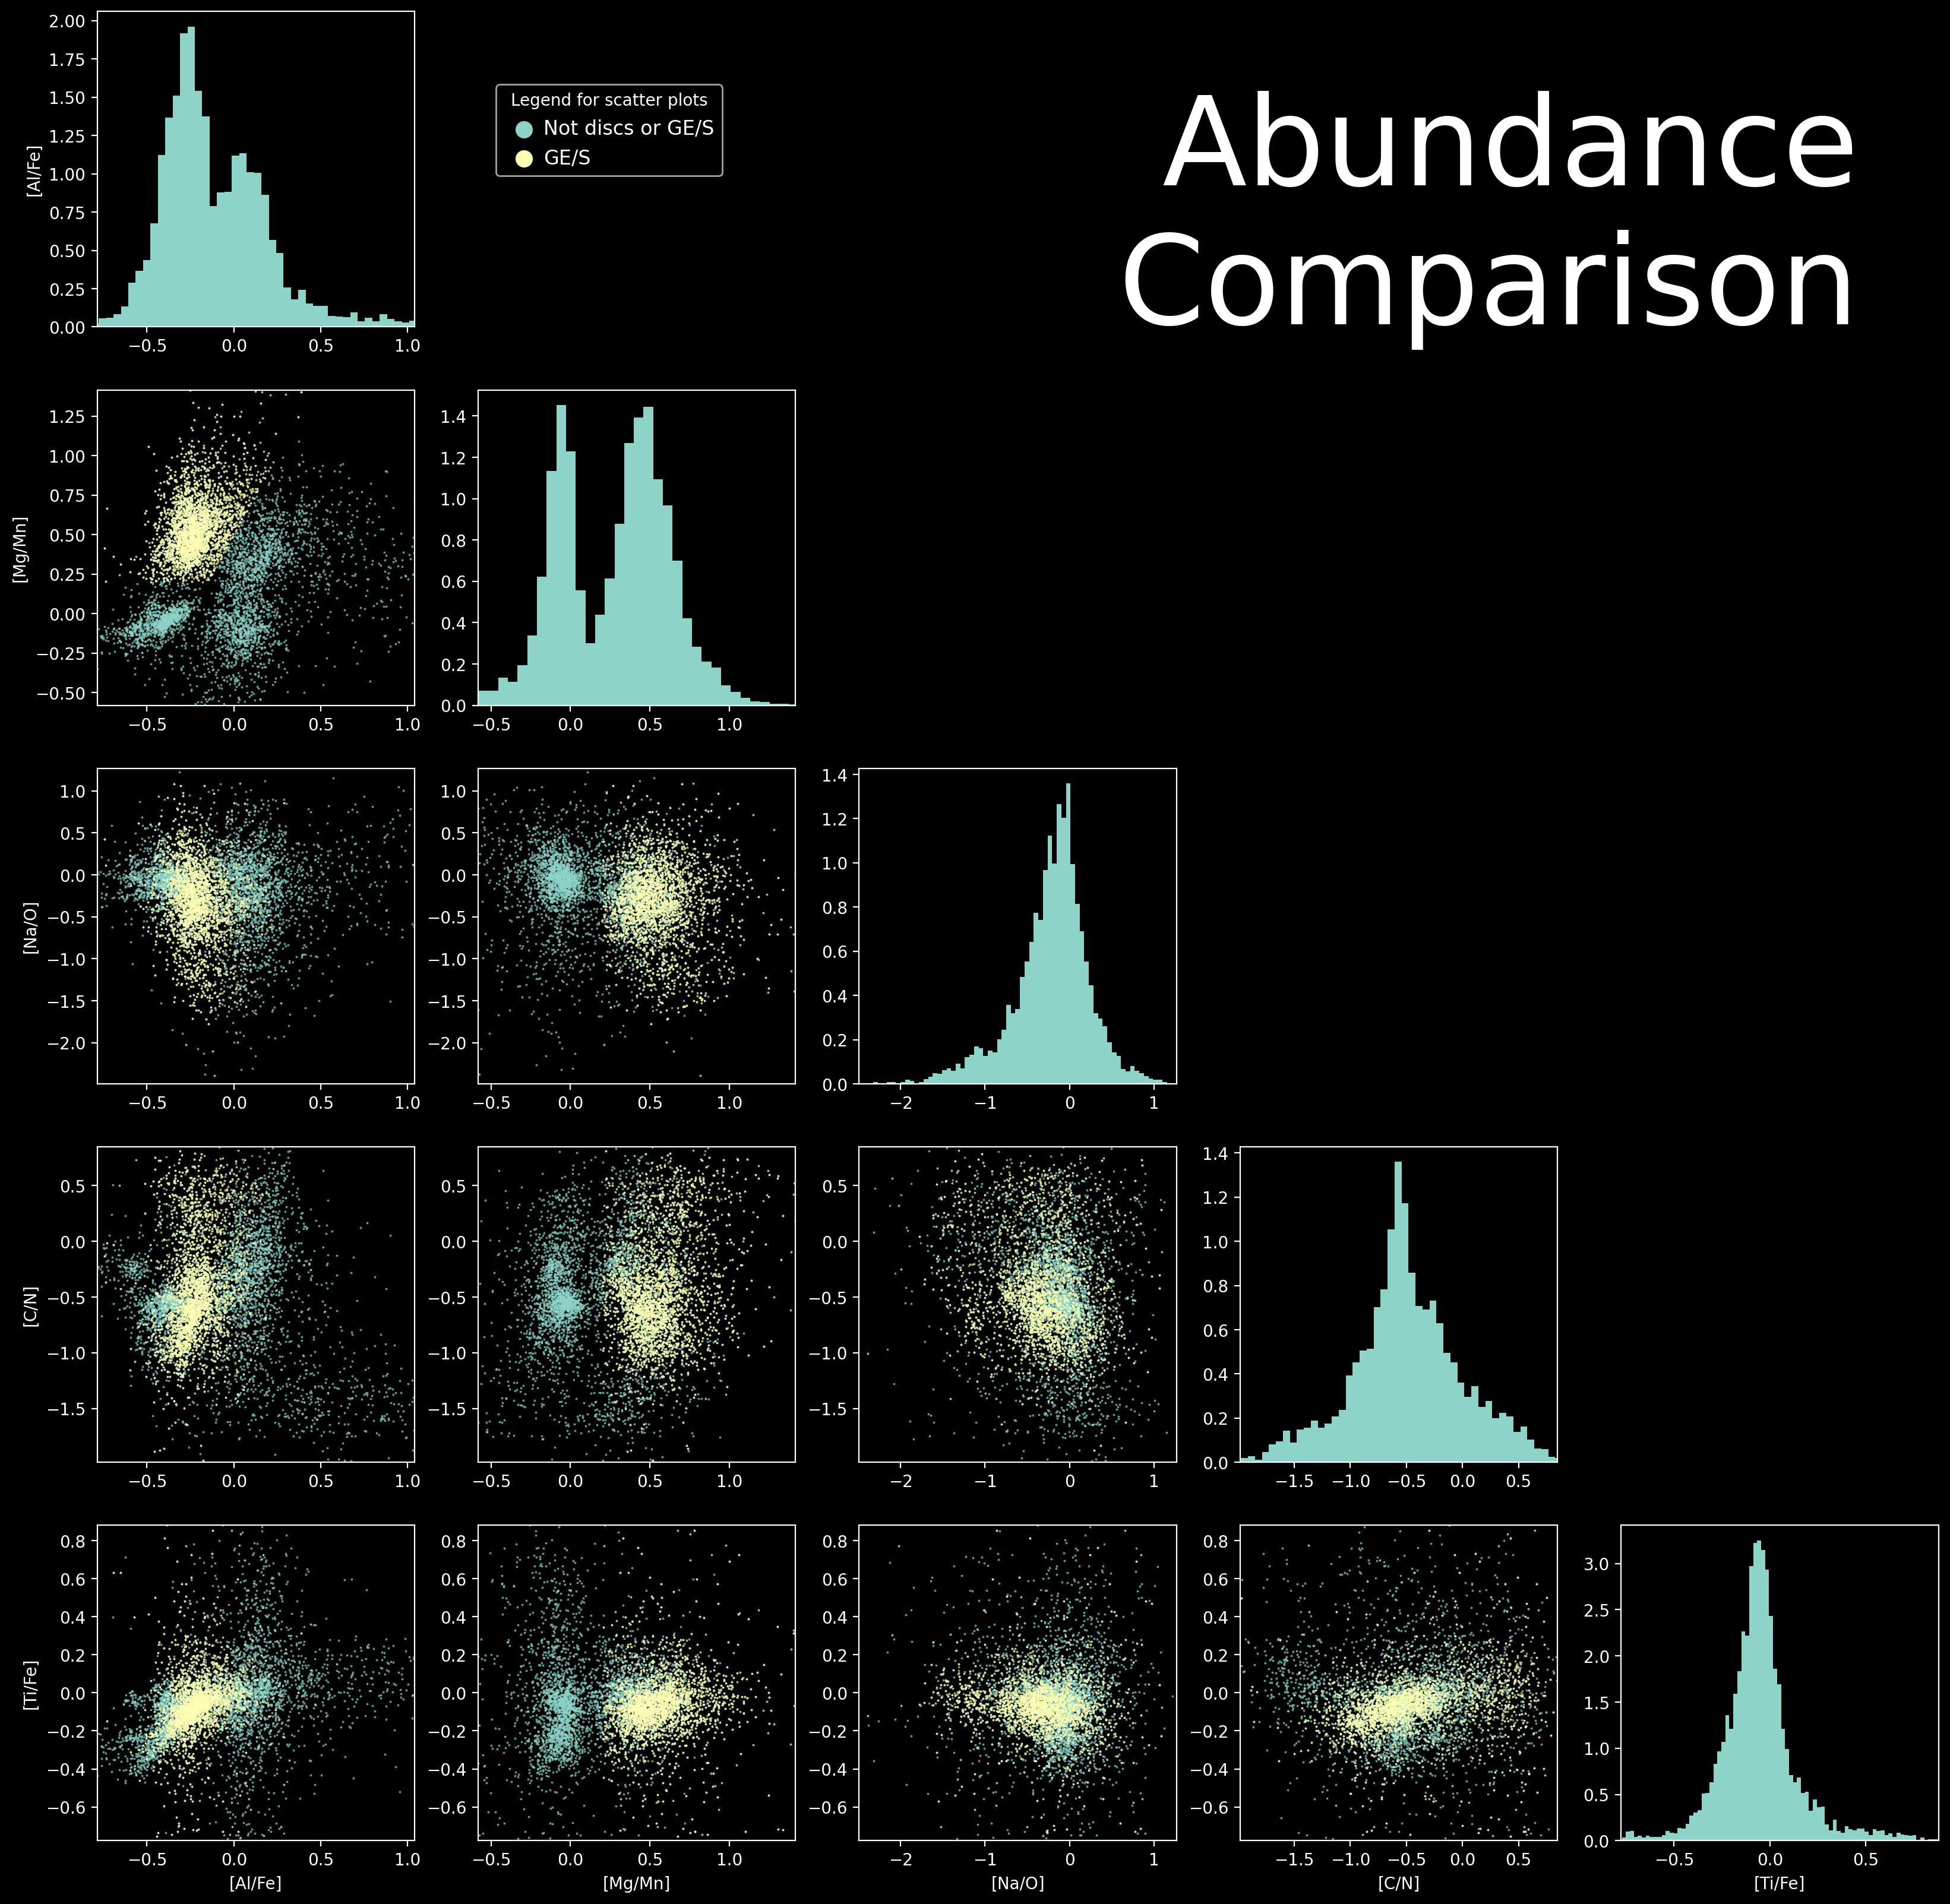

In [227]:
compare_abundances([("AL", "FE"),
                    ("MG", "MN"),
                    ("NA", "O"),
                    ("C", "N"),
                    ("TI", "FE")],
                    highlight_sausage=True, include_discs=False)

So I just picked some relatively random combinations here. The most interesting row seems to be the [C/N] one so let's try pulling one of these clumps out. These seems to be a circle of points that we can mask out.

In [209]:
c_n = df["C_FE"].values - df["N_FE"].values
cn_feature = ((al_fe - -0.6)**2 + (c_n - -0.2)**2 < 0.015) & not_disc

Let's do a quick check to see if we grabbed them properly

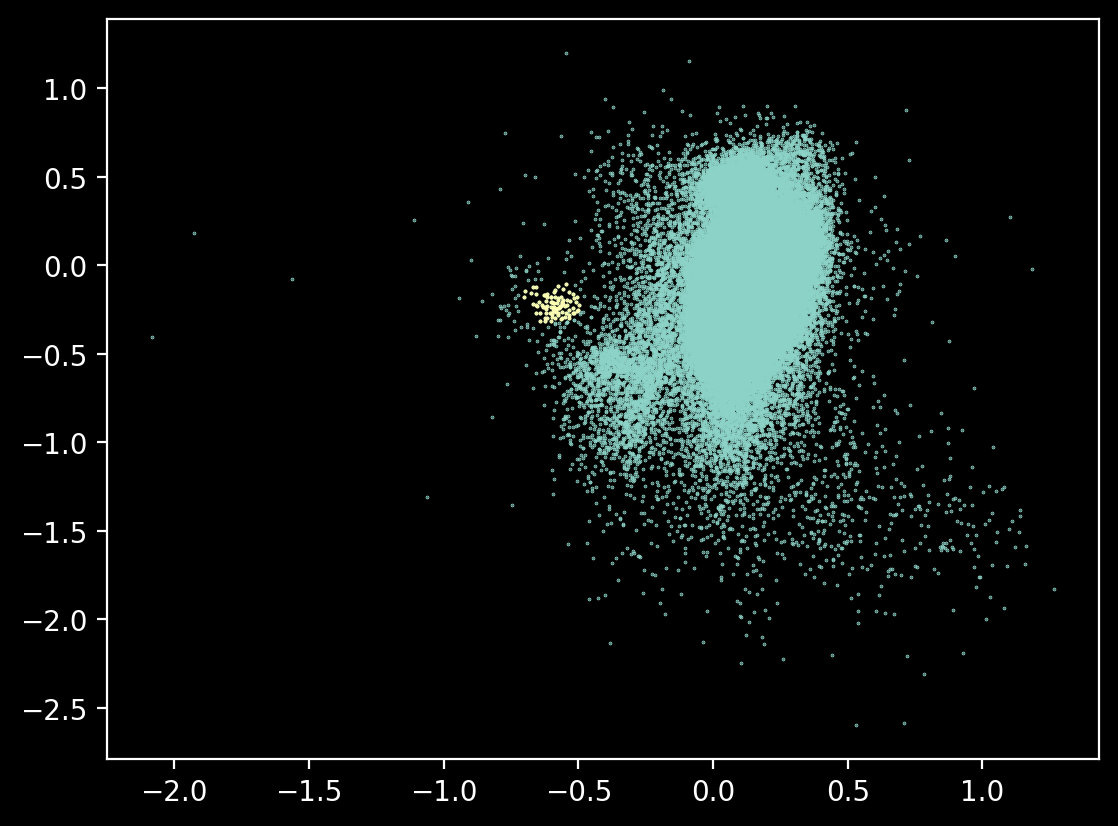

In [338]:
plt.scatter(al_fe, c_n, s=0.1)
plt.scatter(al_fe[cn_feature], c_n[cn_feature], s=0.2);

Yup looks good, let's investigate!

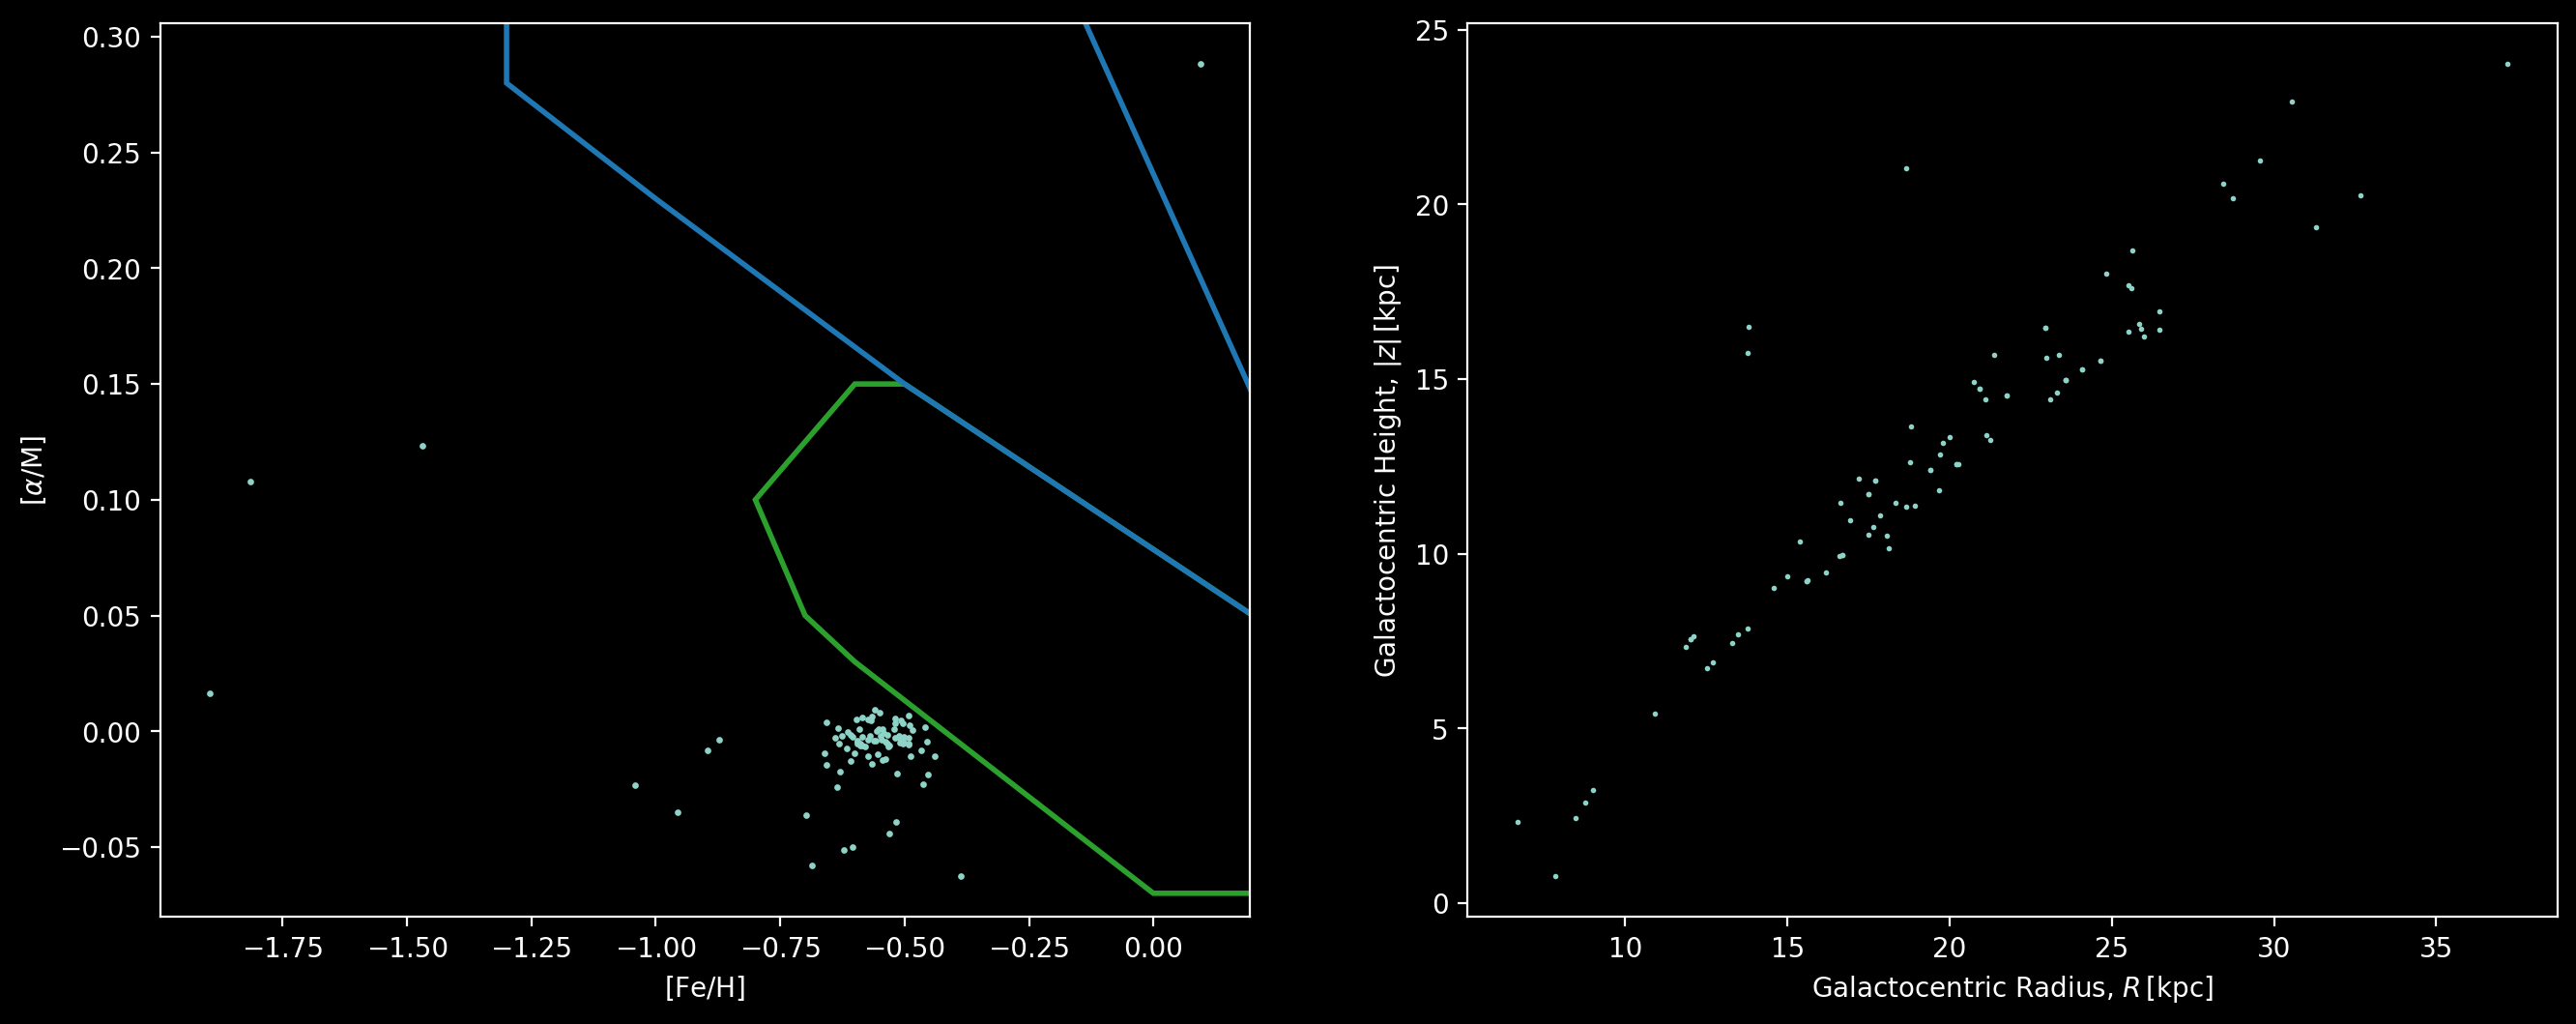

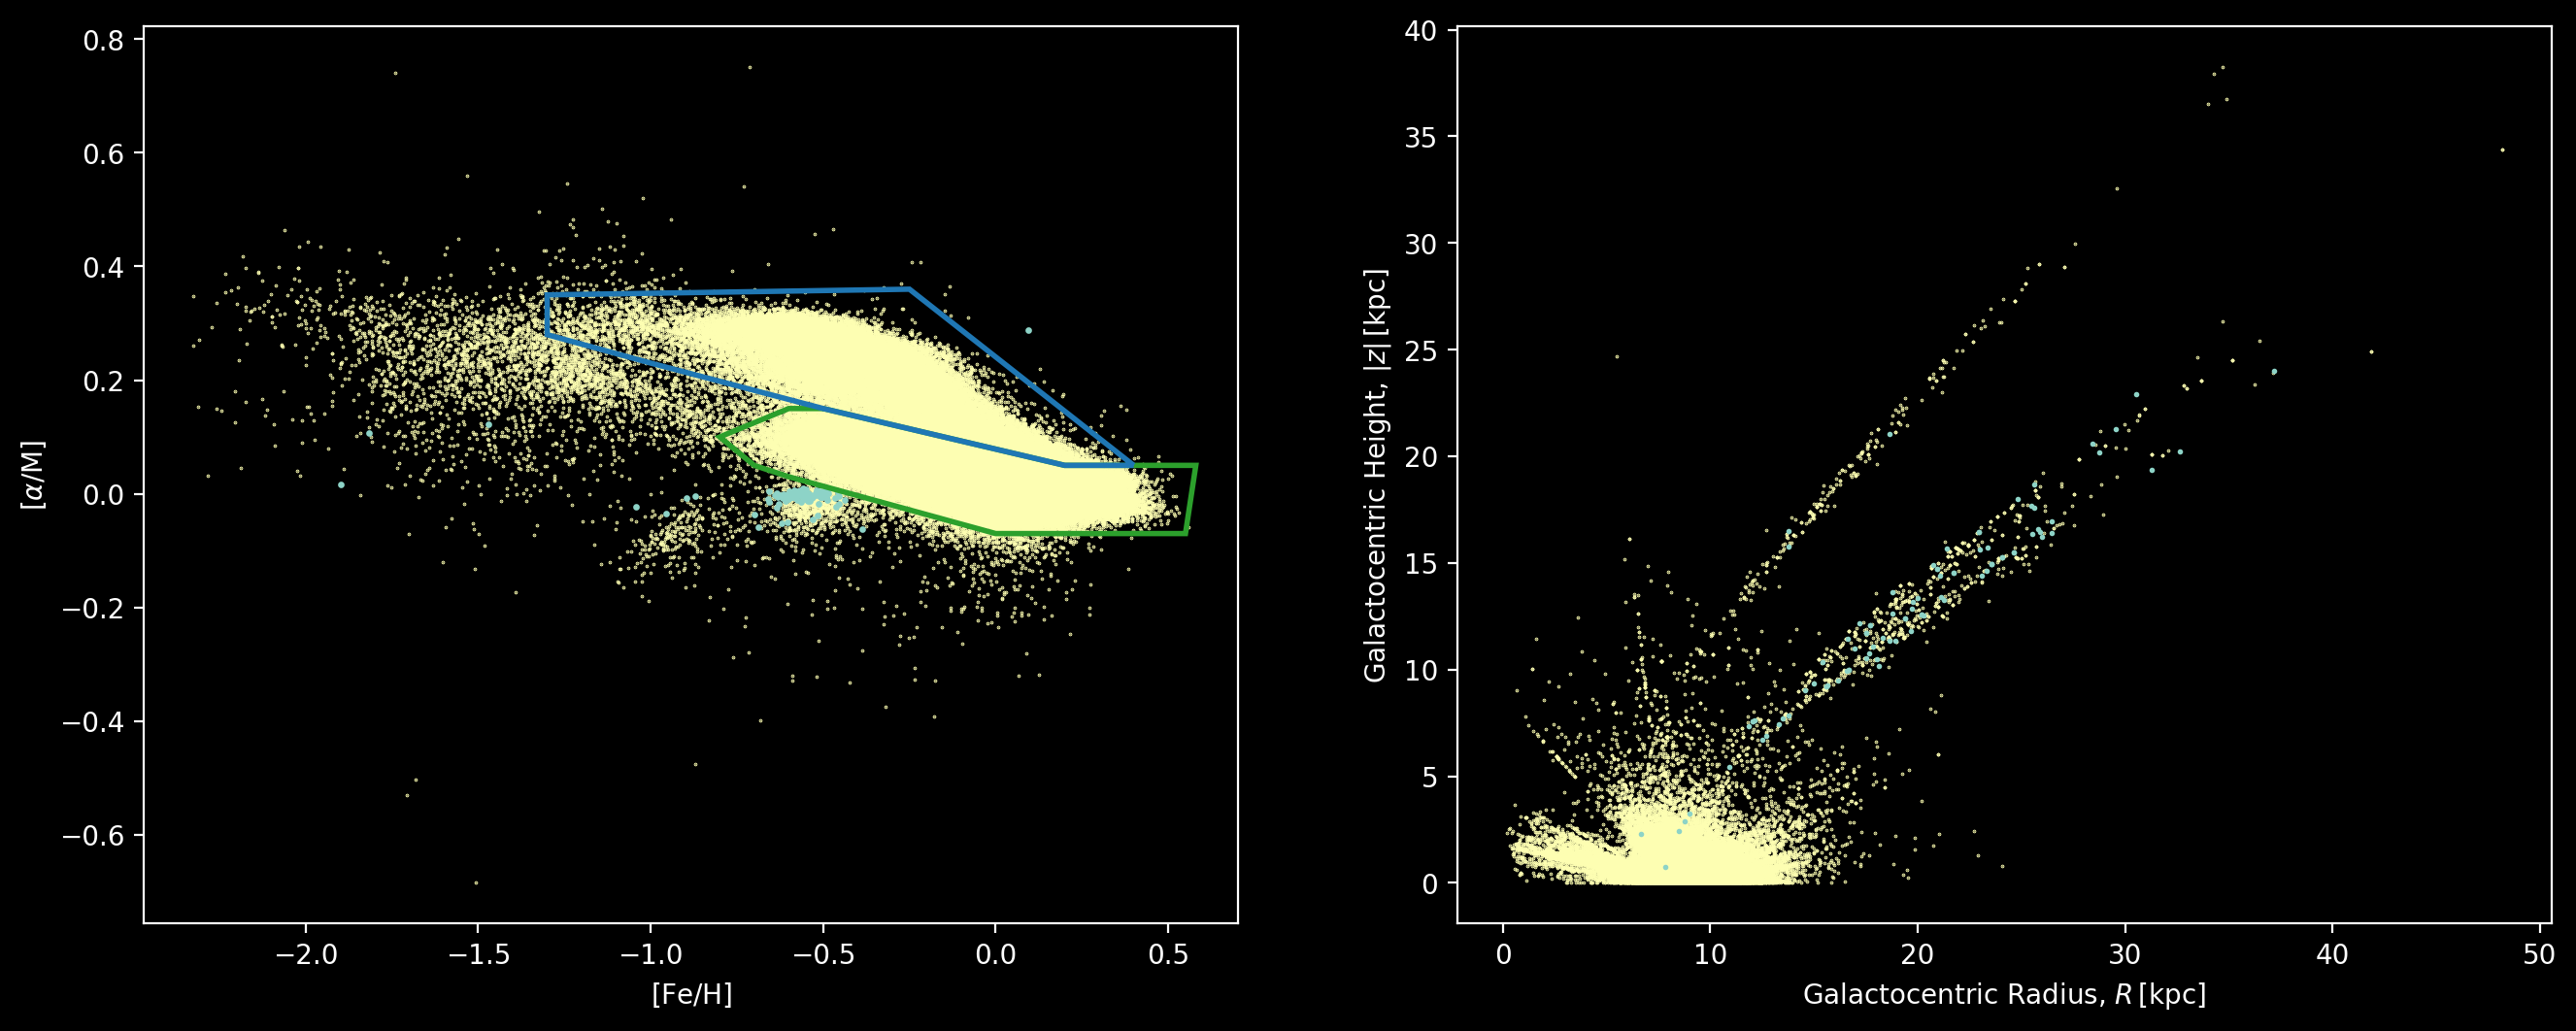

In [217]:
investigate_mask(cn_feature)
investigate_mask(cn_feature, show_background=True)

Ah...hahaha, I have just managed to mask the exact population (but a little less cleanly). So I guess [C/N] works similarly to [Mg/Mn] in distinguishing things.

#### Velocity stuff
One last thing I was intrigued by was the $v_R, v_\phi$ plot that I saw in the last lecture. Let's play around with that too, `Gala` makes this easy too!

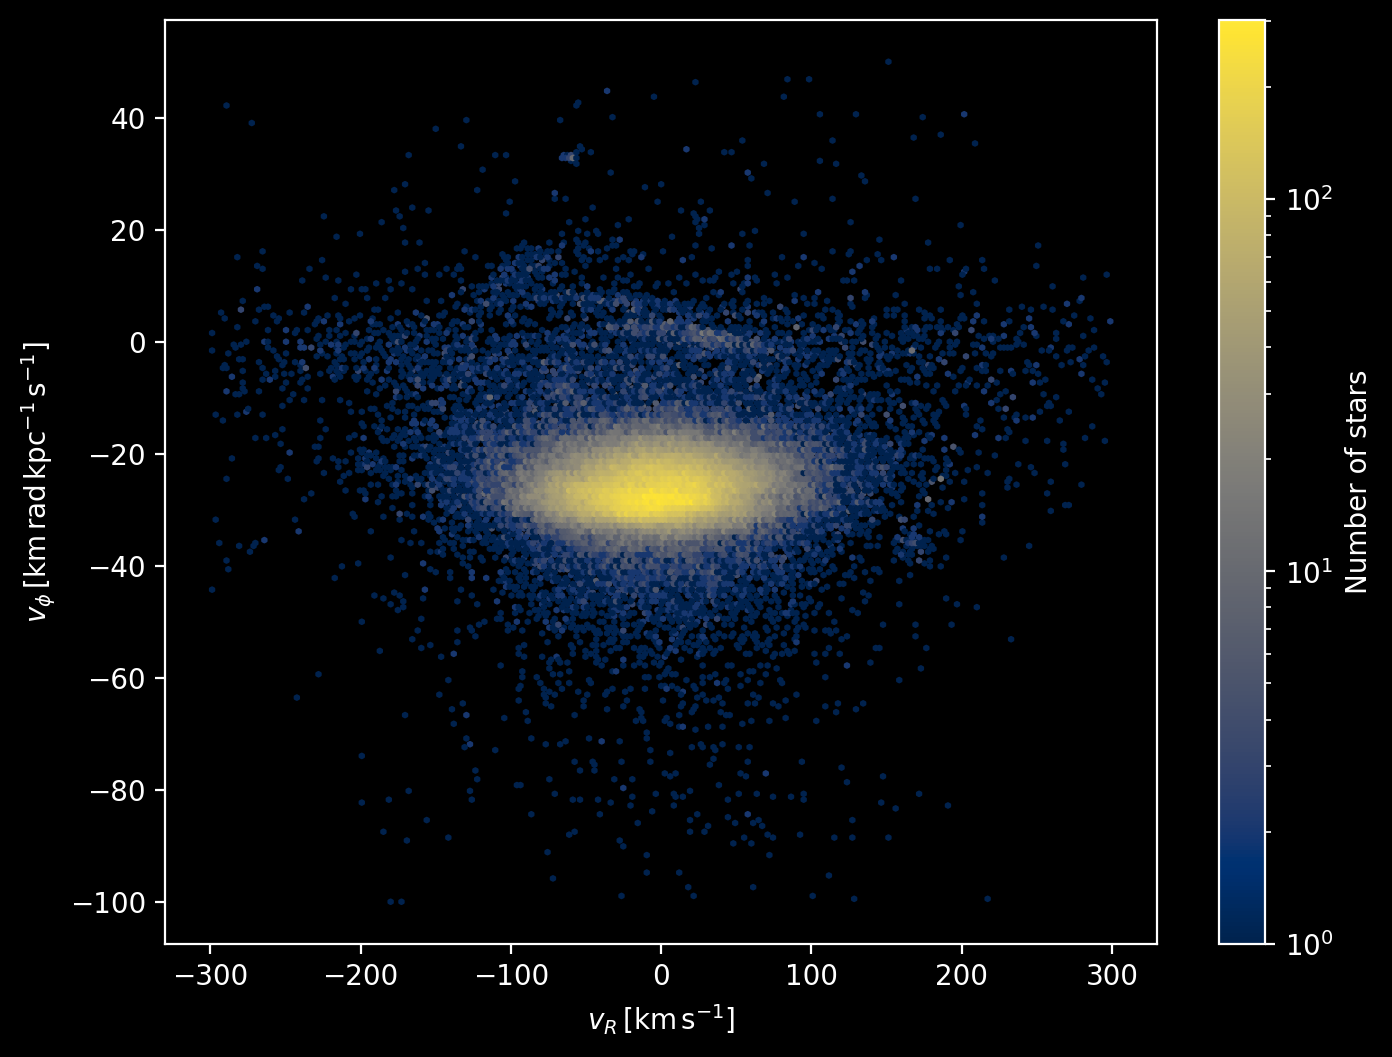

In [250]:
fig, ax = plt.subplots(figsize=(8, 6))

hexbin = ax.hexbin(w.cylindrical.v_rho, w.cylindrical.pm_phi, bins="log",
                   extent=(-300, 300, -100, 50), cmap="cividis", gridsize=250)

fig.colorbar(hexbin, label="Number of stars")

ax.set_xlabel(r"$v_R \, [\rm km \, s^{-1}]$")
ax.set_ylabel(r"$v_\phi \, [\rm km \, rad \, kpc^{-1} \, s^{-1}]$")

plt.show()


Okay cool I see _several_ interesting features in here. Let's check that they're not familiar things before investigating too much. It was quite fun to peel back the layers of the onion like this

In [339]:
def v_plot(mask=None, title="", scatter=False):
    if mask is None:
        mask = np.repeat(True, len(df))

    fig, ax = plt.subplots(figsize=(8, 6))

    if scatter:
        ax.scatter(w.cylindrical.v_rho[mask], w.cylindrical.pm_phi[mask], s=0.1)
        ax.set_xlim(-300, 300)
        ax.set_ylim(-100, 50)
    else:
        hexbin = ax.hexbin(w.cylindrical.v_rho[mask], w.cylindrical.pm_phi[mask], bins="log",
                        extent=(-300, 300, -100, 50), cmap="cividis", gridsize=200)

        fig.colorbar(hexbin, label="Number of stars")

    ax.set_xlabel(r"$v_R \, [\rm km \, s^{-1}]$")
    ax.set_ylabel(r"$v_\phi \, [\rm km \, rad \, kpc^{-1} \, s^{-1}]$")

    ax.set_title(title)

    plt.show()

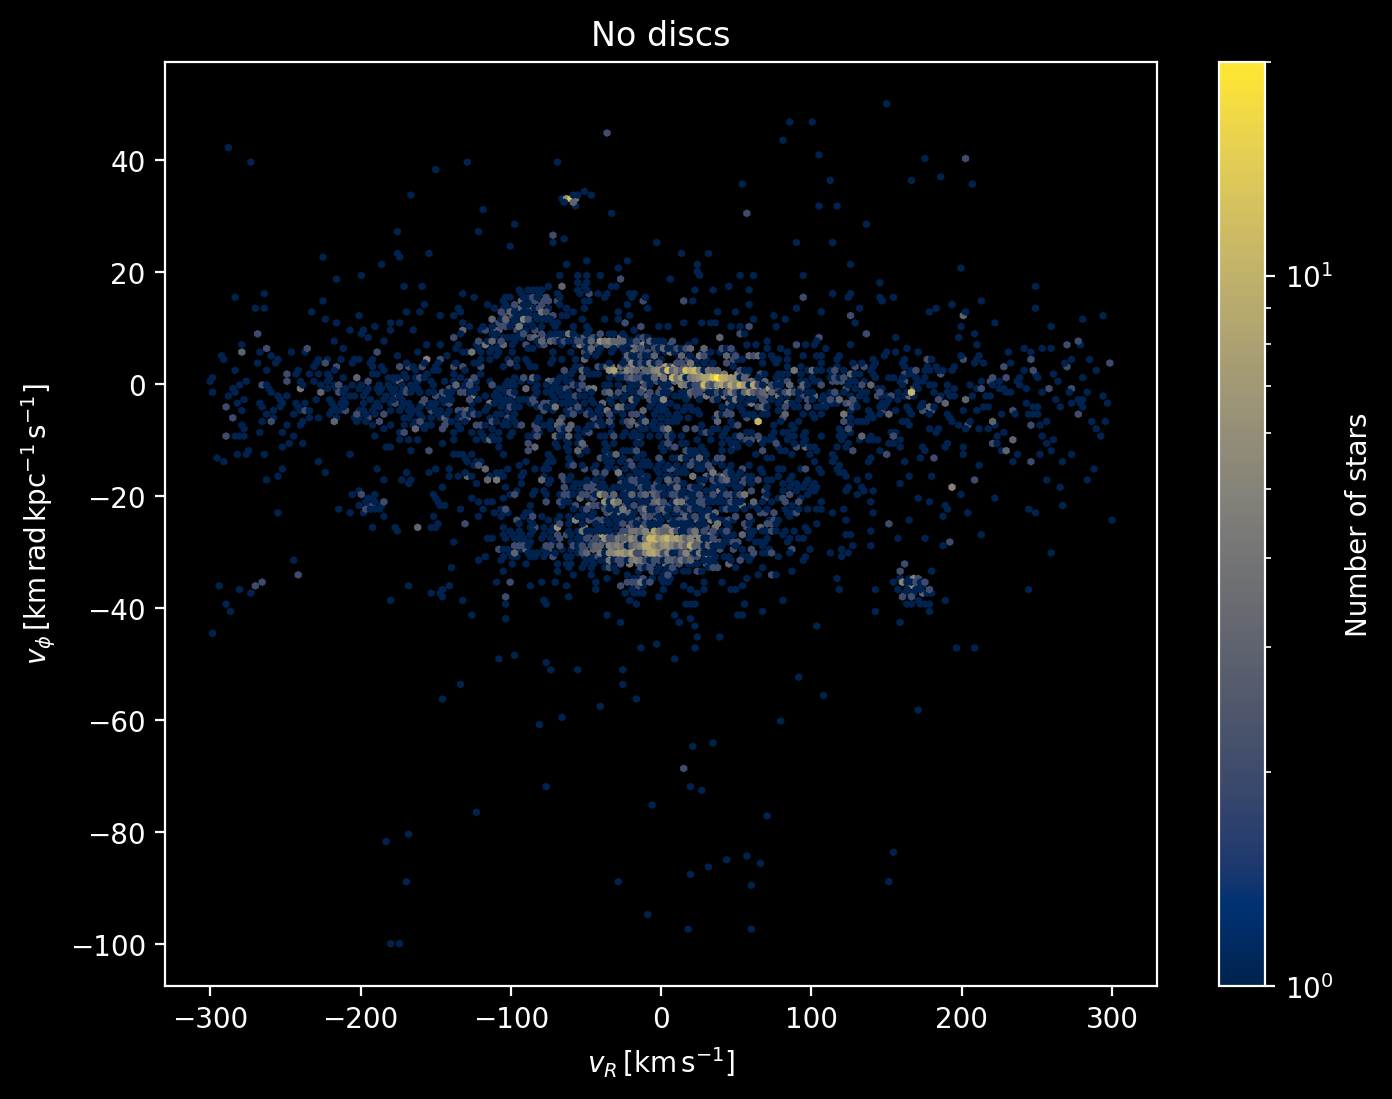

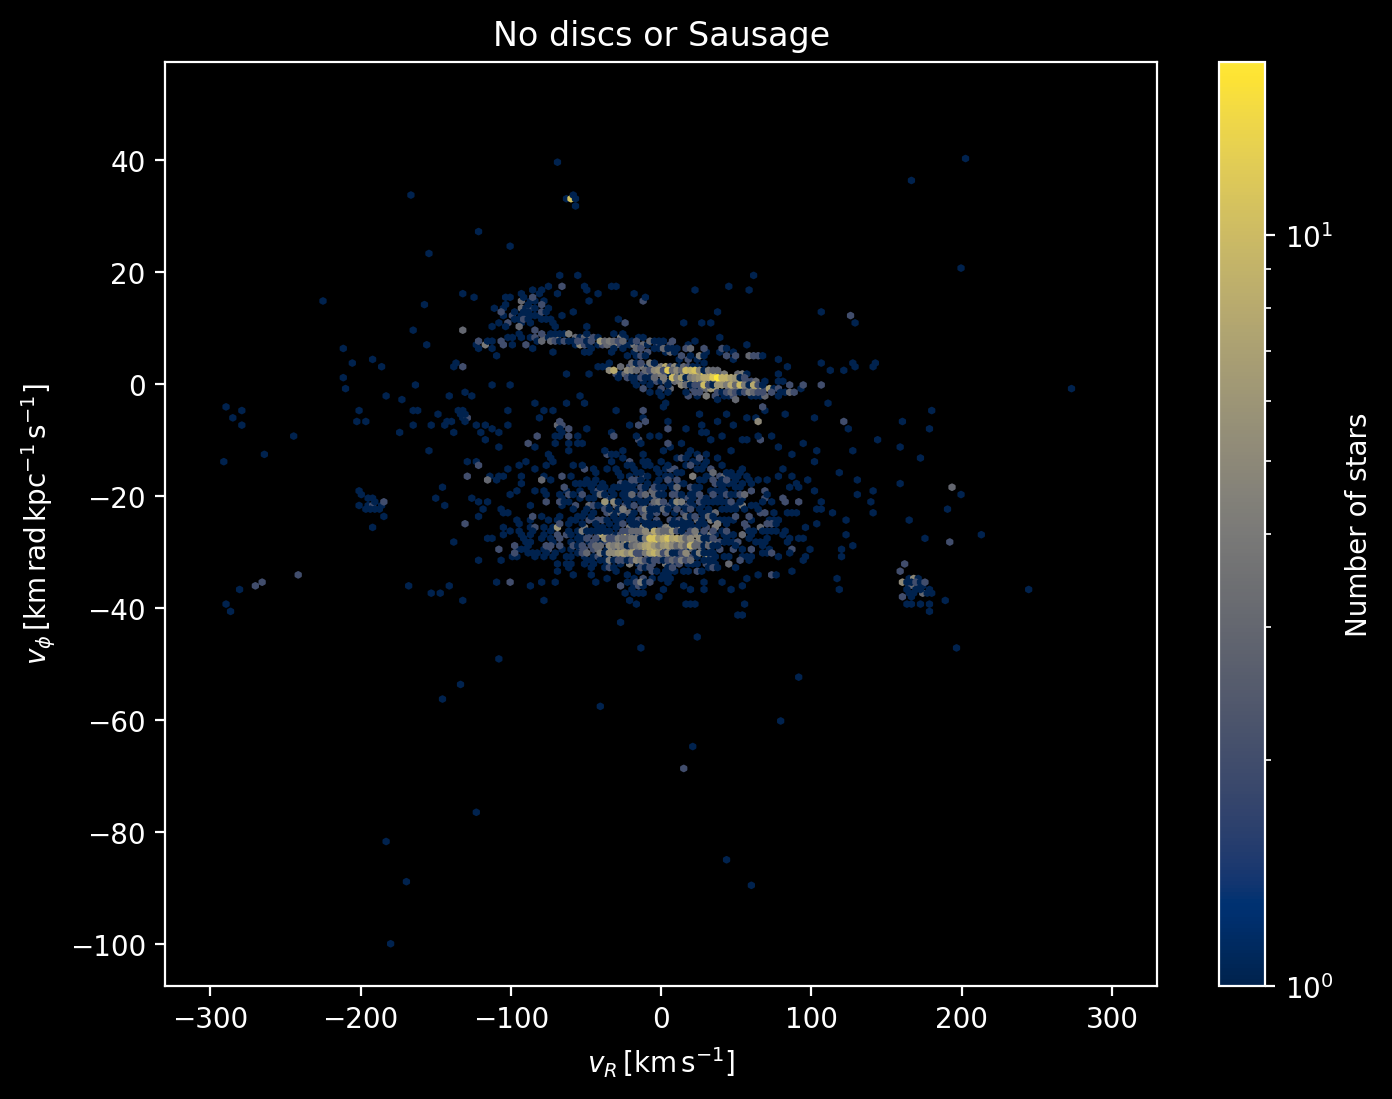

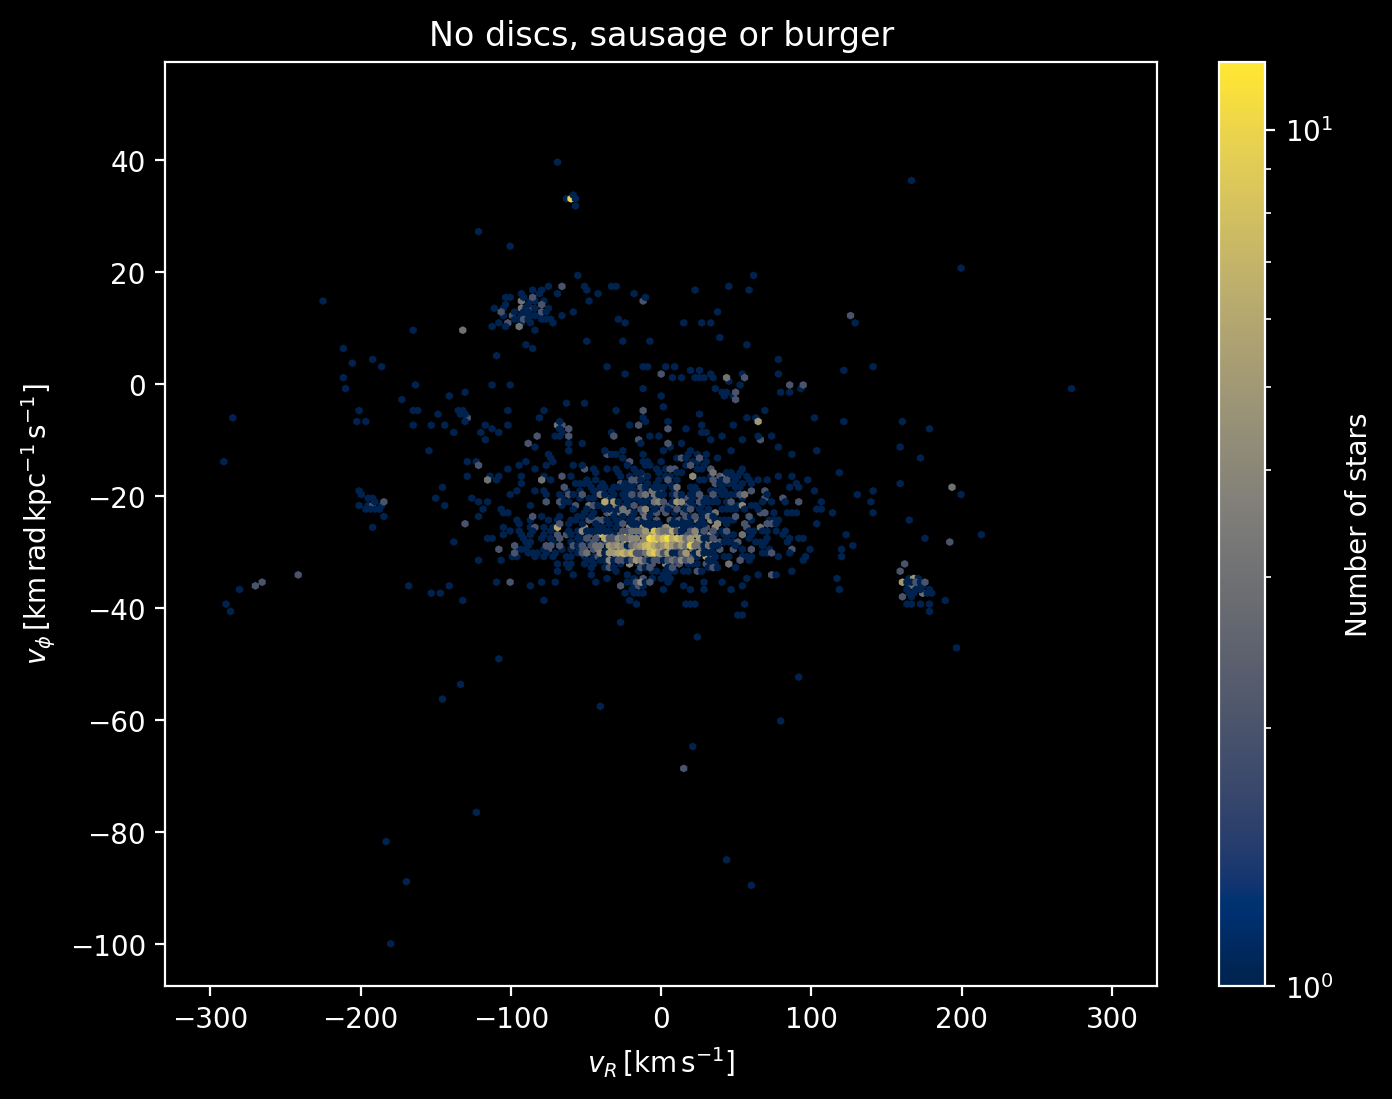

In [288]:
v_plot(not_disc, "No discs")
v_plot(not_disc & ~(sausage_chemical | sausage_kin), "No discs or Sausage")
v_plot(not_disc & ~(sausage_chemical | sausage_kin) & ~burger, "No discs, sausage or burger")

There aren't many by the last plot so we could just scatter those

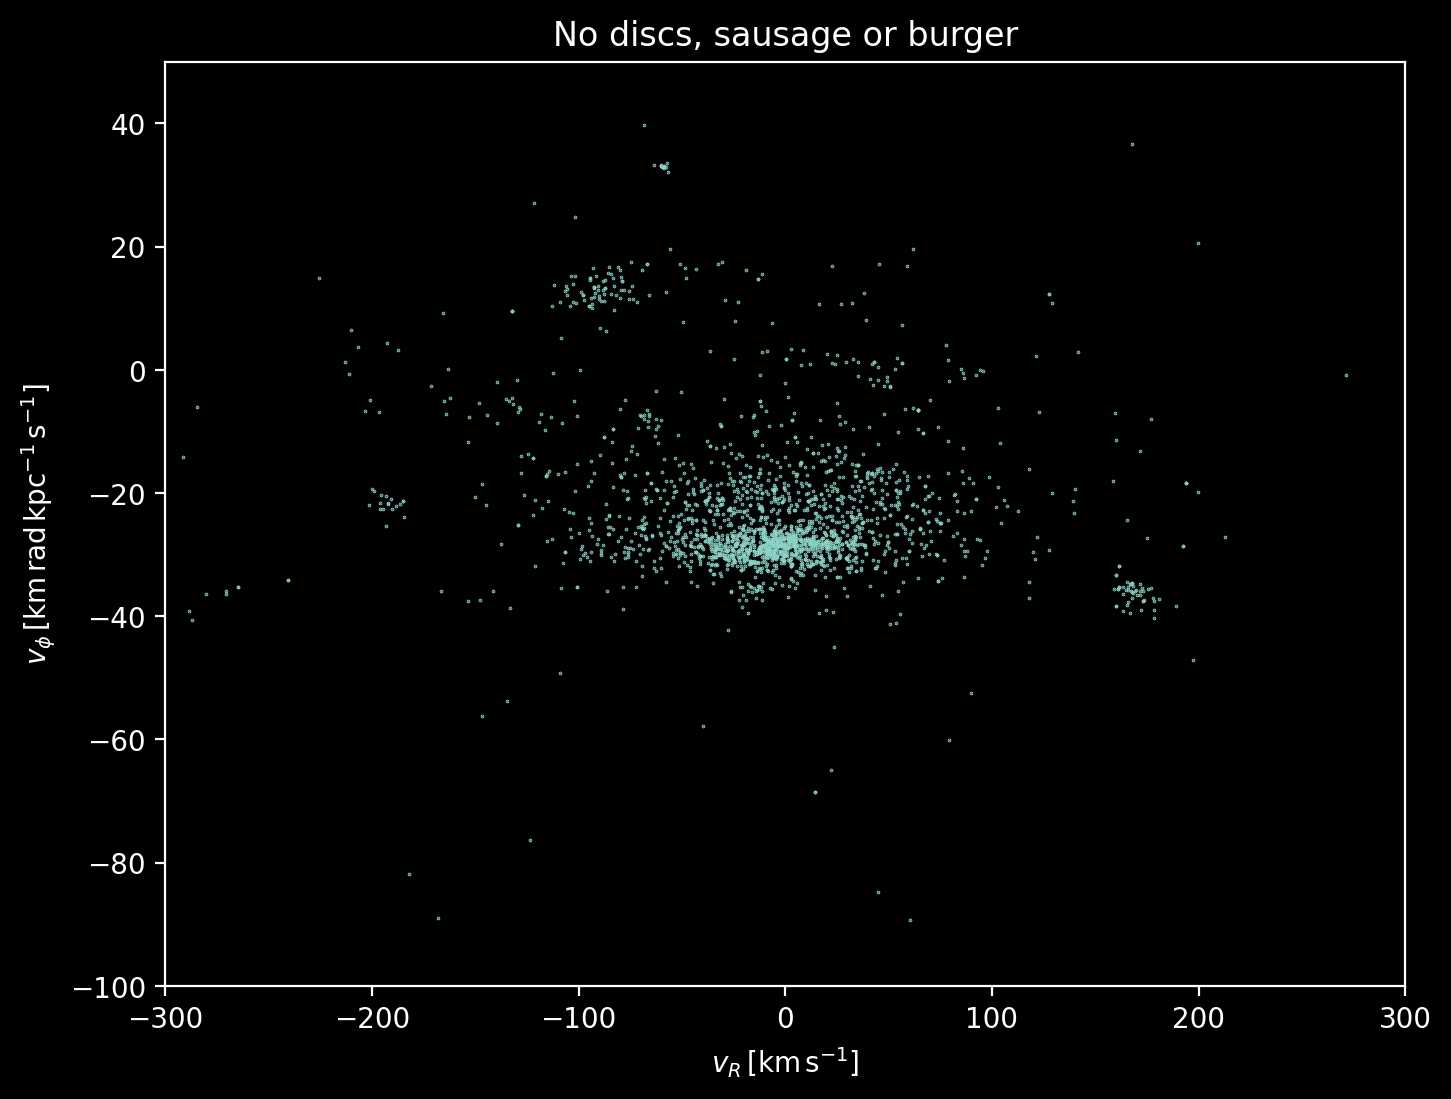

In [340]:
v_plot(not_disc & ~(sausage_chemical | sausage_kin) & ~burger, "No discs, sausage or burger", scatter=True)

So there are definitely still some things left after that! I'm most interested in the big clumps on the outskirts plus that teeny one at the top that seems to have a bunch of stars (I'm guessing the thing in the middle is just stars that I missed from other things?). Let's just focus on a clump and the dense point. Go go gadget masks

In [329]:
v_R = w.cylindrical.v_rho.to(u.km / u.s).value
v_phi = w.cylindrical.pm_phi.to(u.km * u.rad / u.kpc / u.s).value

not_other_stuff = not_disc & ~(sausage_chemical | sausage_kin) & ~burger
clump = (v_R > 150) & (v_R < 200) & (v_phi > -45) & (v_phi < -30) & not_other_stuff
cluster = (v_R > -80) & (v_R < -50) & (v_phi > 32) & (v_phi < 37) & not_other_stuff

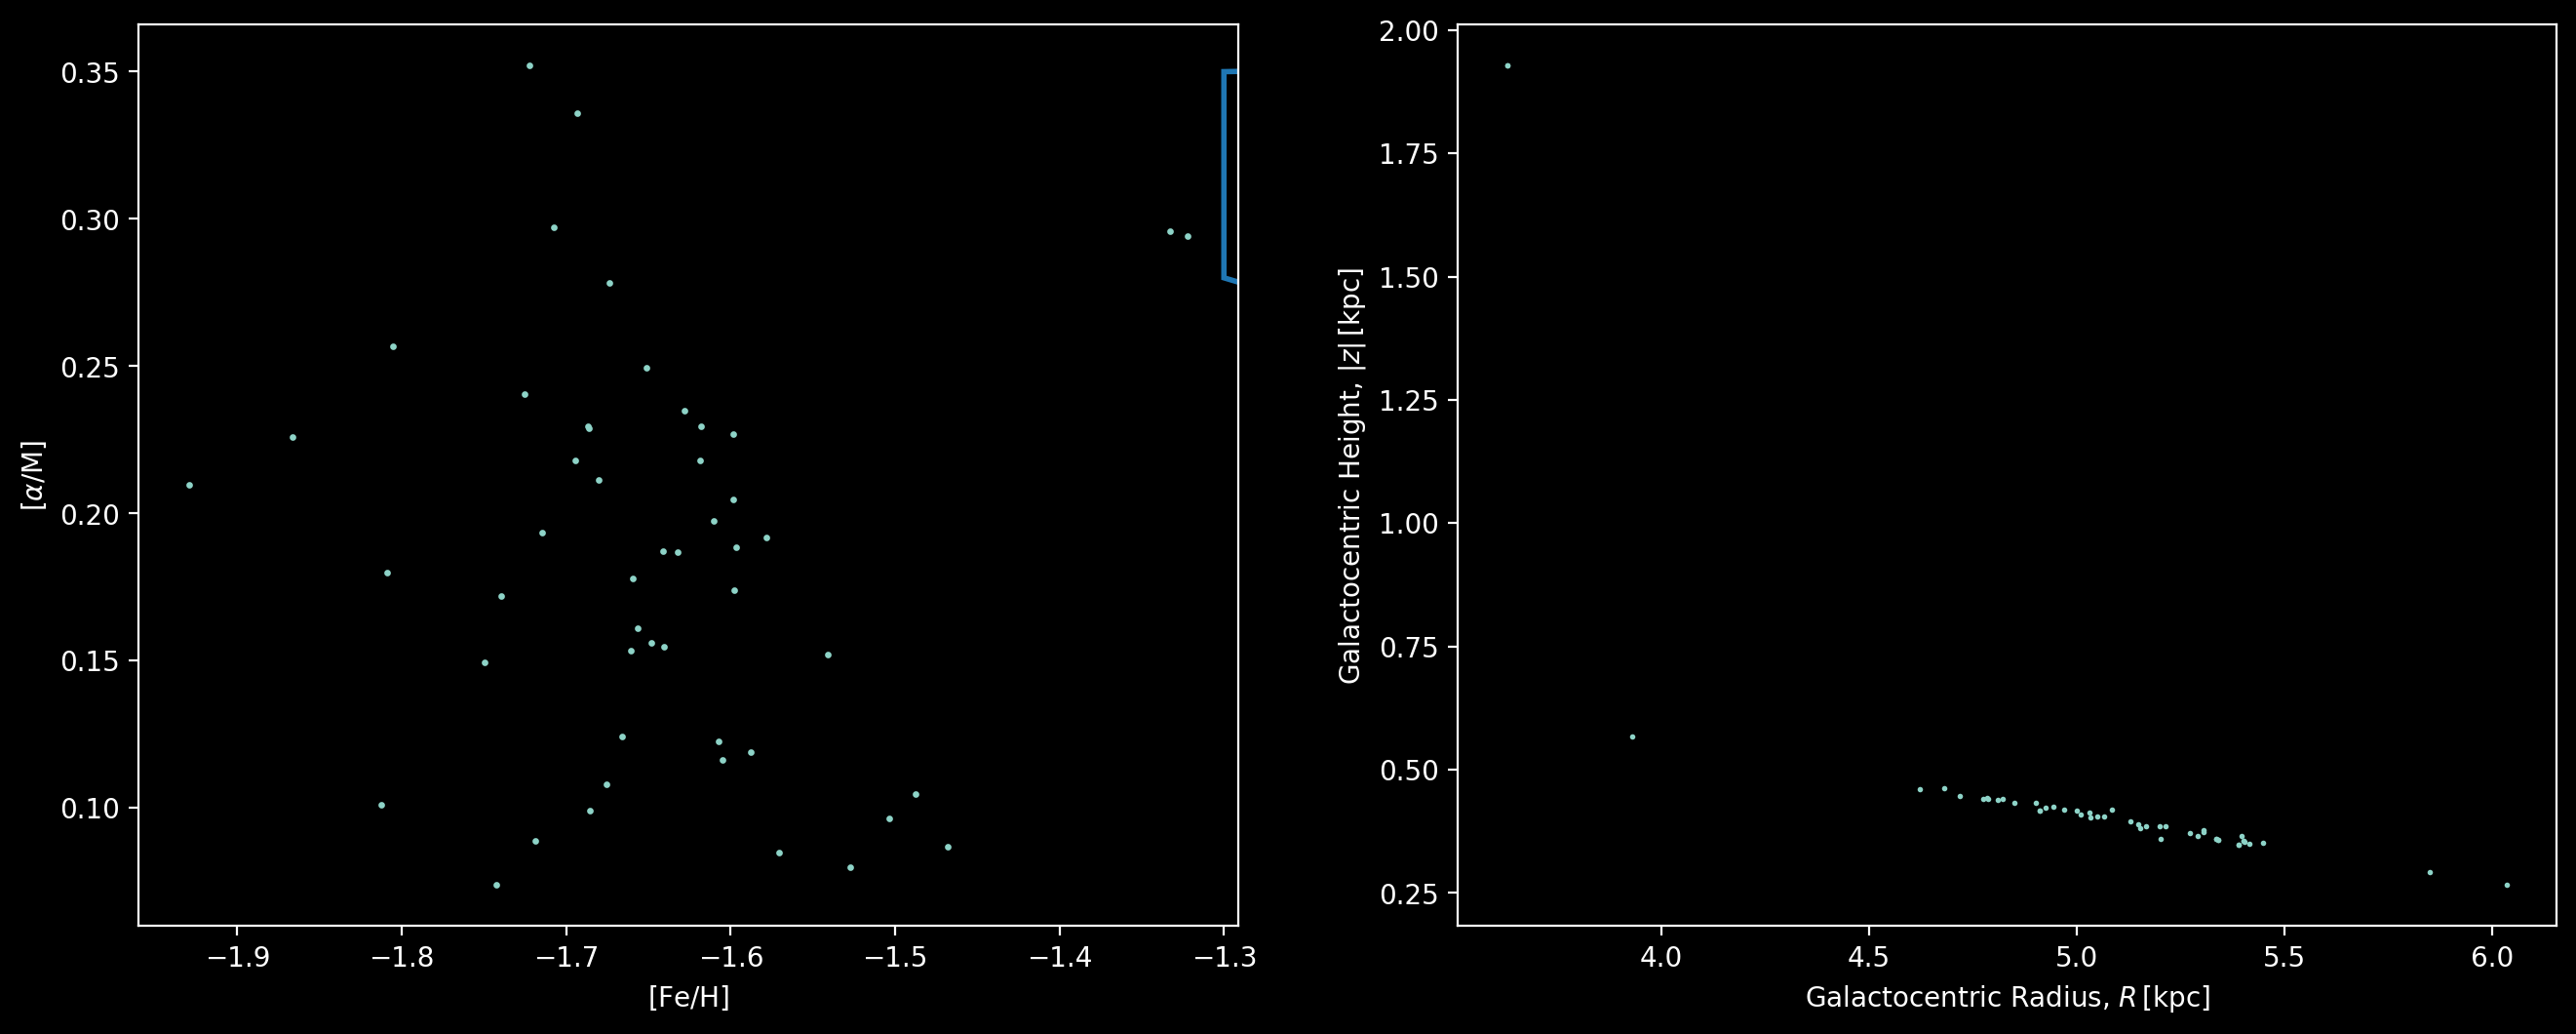

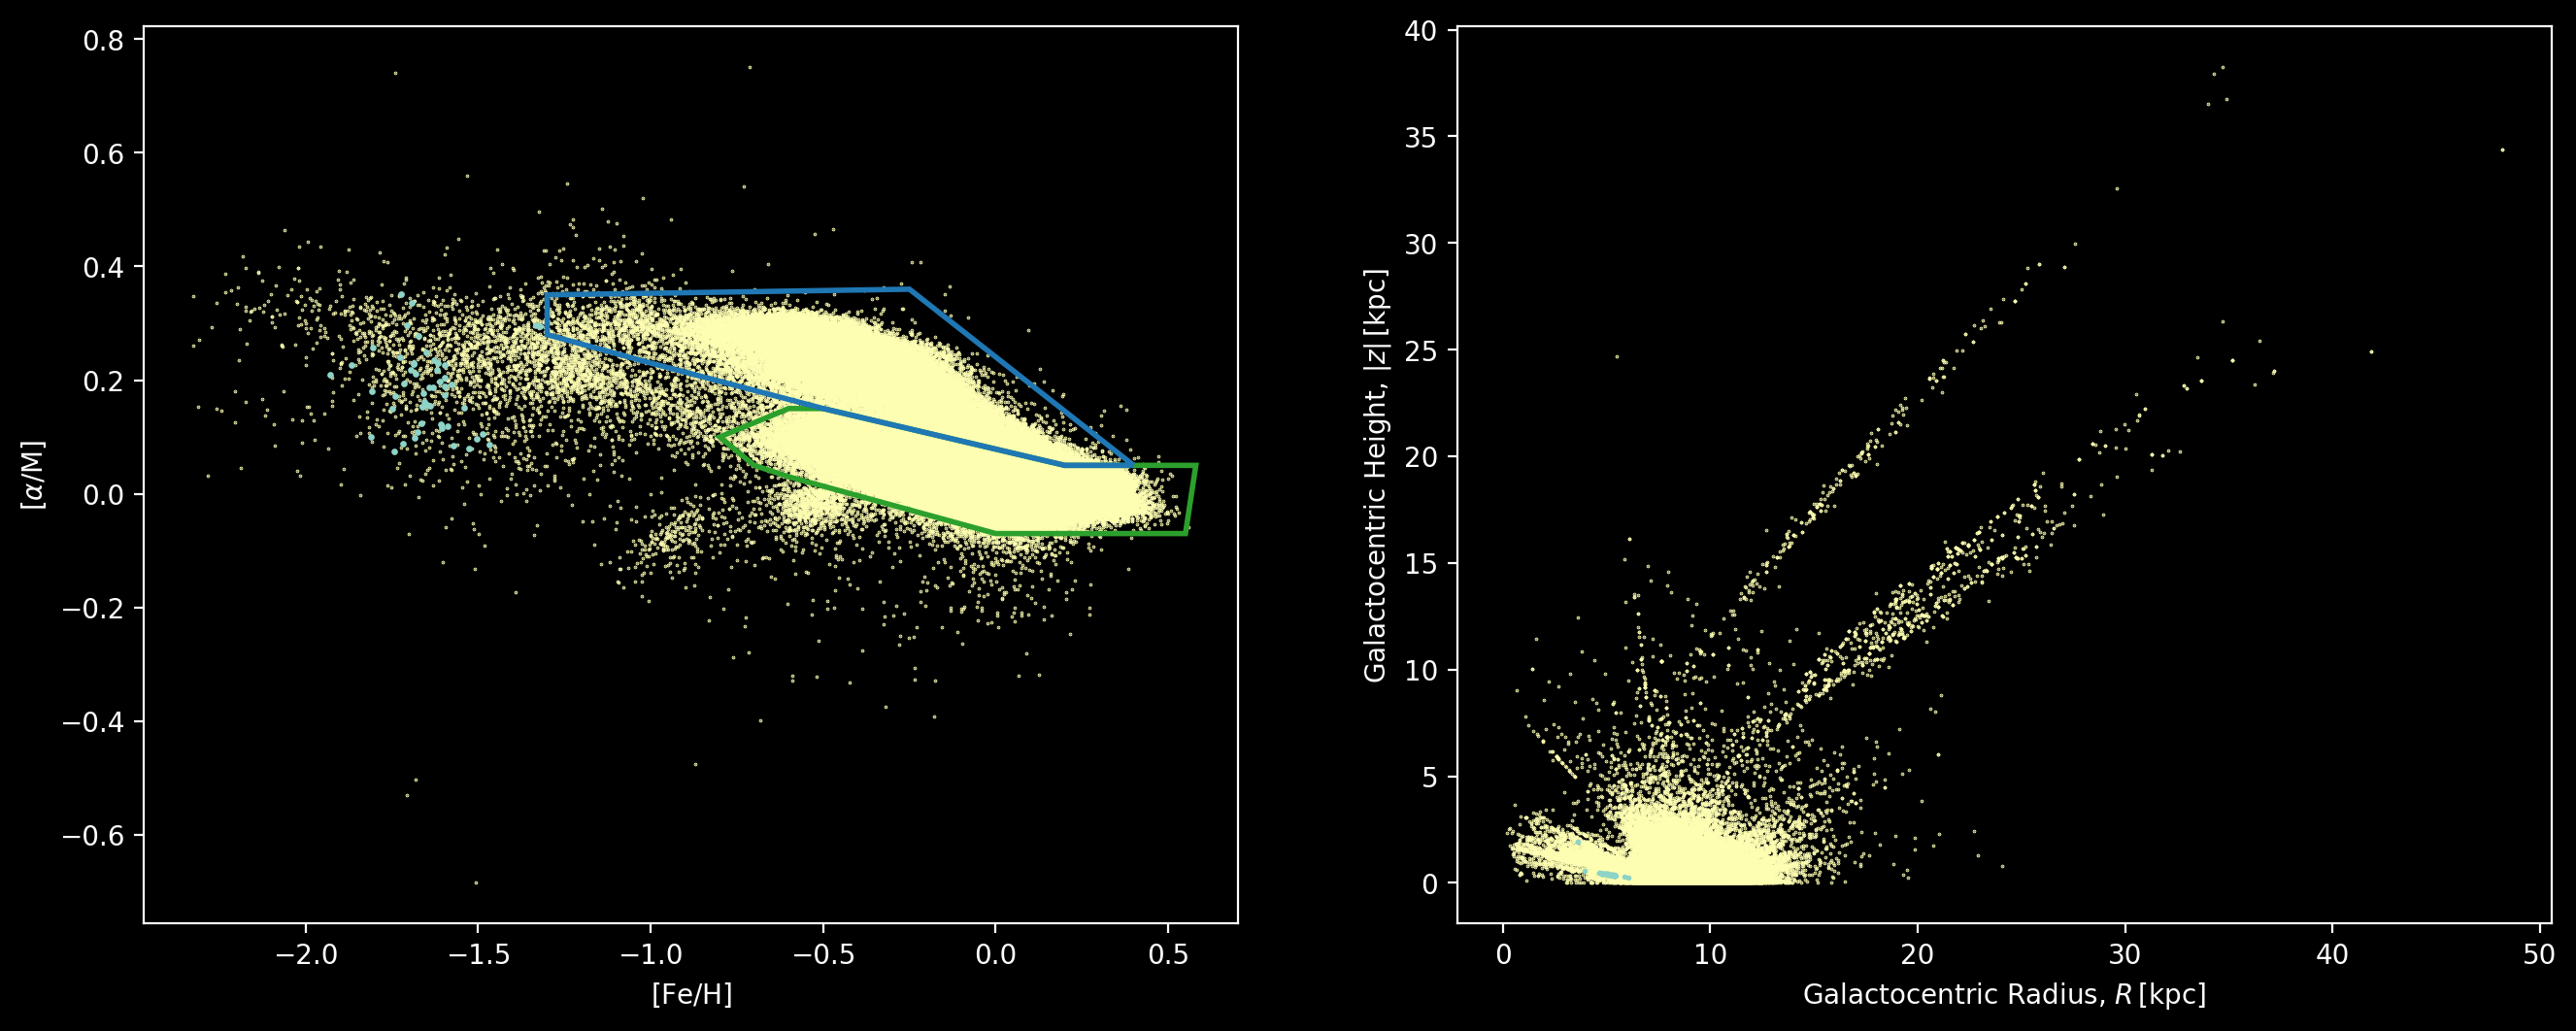

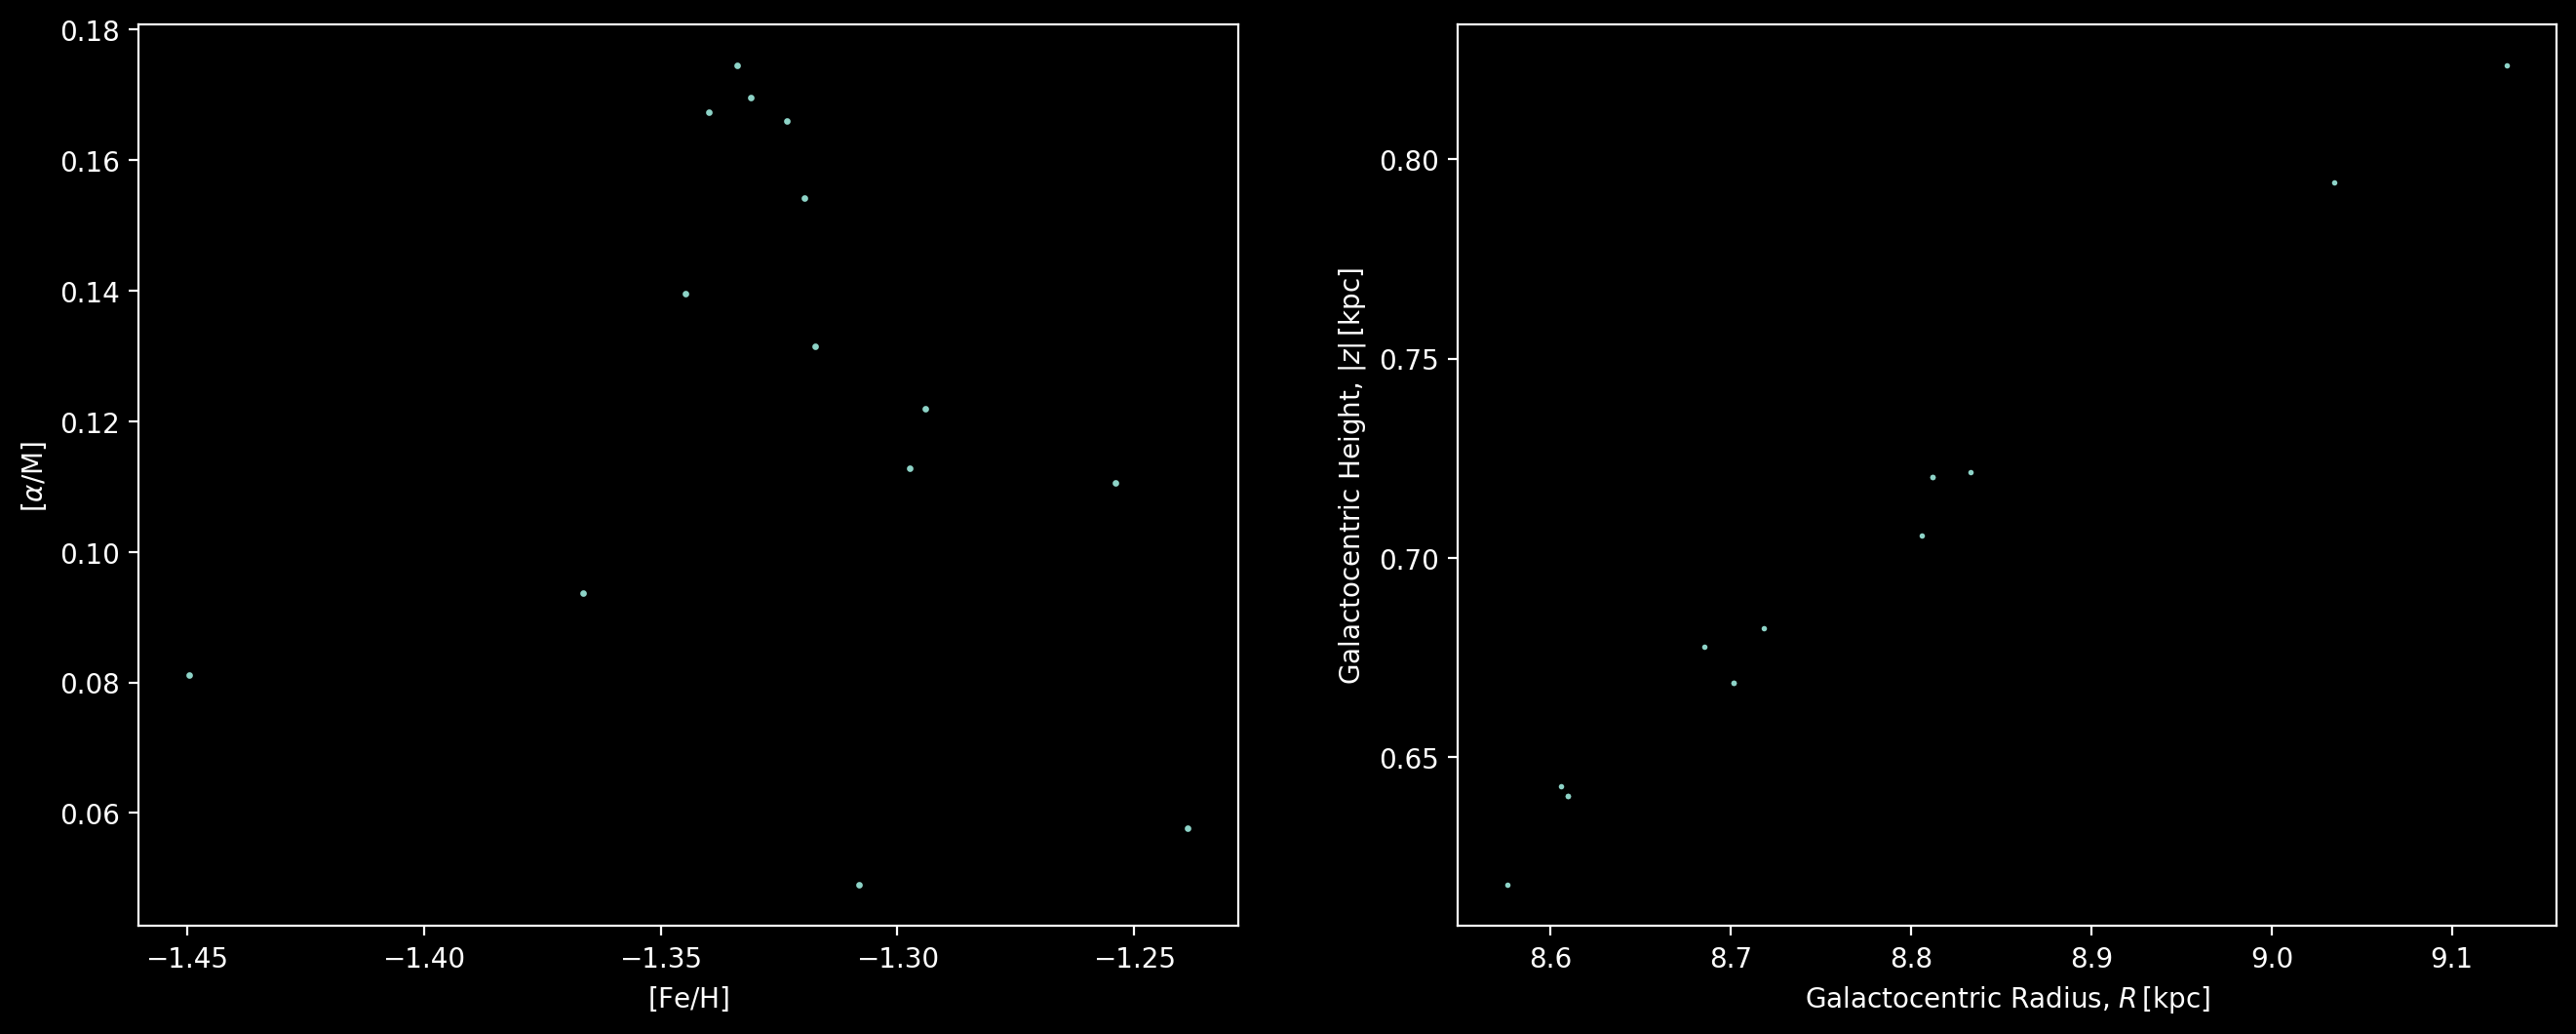

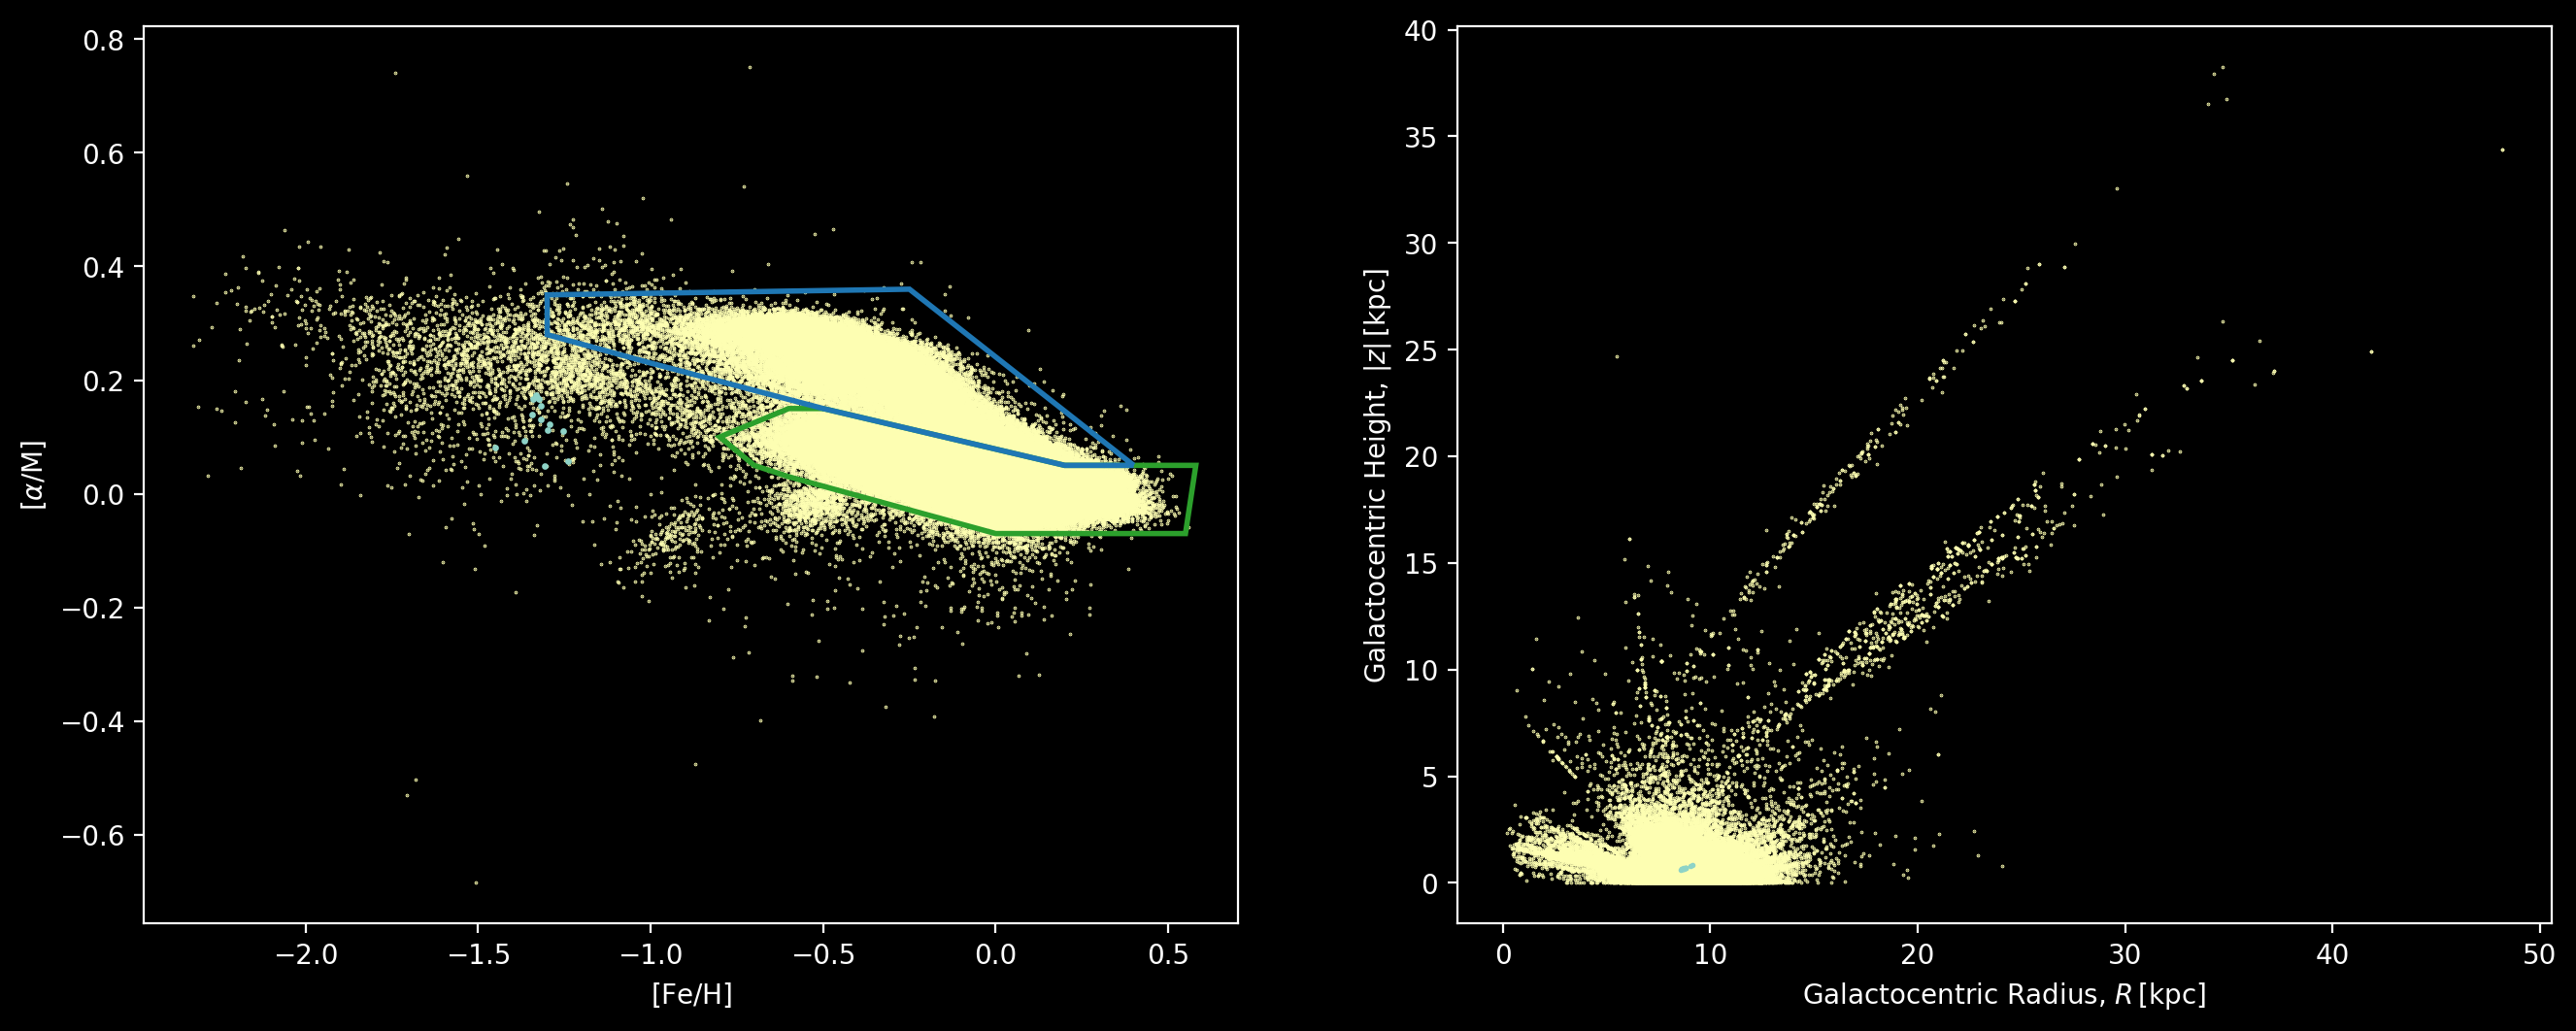

In [333]:
for thing in [clump, cluster]:
    investigate_mask(thing, show_background=False)
    investigate_mask(thing, show_background=True)

Well these looks like two fairly co-located and co-moving collections of stars (definitely the `cluster` one at least). The abundances also look fairly consistent but with a bit more of a spread.

If I had more time I'd want to cross reference some of these and see if they are real and check out the other collections you can see in the $v_R-v_\phi$ plot. But alas, I am called away. This was fun, thanks Jim!